In [ ]:
# ClinVar -> osteosarcoma gene panel + explicit label policy + documentation metrics

import pandas as pd
from collections import Counter
from src.datasets.clinvar import load_clinvar
from sklearn.model_selection import train_test_split

# ---- Source rationale ----
GENE_SOURCE = "PMID: 27760307 (osteosarcoma somatic mutation studies)"

GENE_SET = {
    "TP53","RB1","RECQL4","BLM","WRN","ATRX","BAP1","RET","MUTYH",
    "ATM","PTEN","NUMA1","MDC1","CDK4","MDM2","MYC","CARD11","EGFR",
    "GNAQ","GNAS","JAK1","MAML2","FBXW7","ALK","PDGFRA","PDGFRB","PIK3CA",
    "APC","CTNND1","CCNE1","COPS3","PDPK1","AKT1","E1F4B","NOTCH1",
    "NOTCH2","NOTCH3","NOTCH4","PRKCA","EP300","SMAD4","RUNX1","ARID1A",
    "BRCA1","BRCA2","MLH1","CBL","PTCH1","NF1","MAP2K4","AKT2","PIK3R1",
    "TSC2","GAS7","MLLT3","DLG2","VHL"
}

# ---- Label policy ----
POS_LABELS = {"Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"}
NEG_LABELS = {"Benign", "Likely_benign", "Benign/Likely_benign"}

def parse_geneinfo(val):
    if val in ("NA", None):
        return []
    return [entry.split(":")[0] for entry in str(val).split("|") if entry]

def parse_label(val):
    if isinstance(val, list):
        return val[0] if len(val) > 0 else "NA"
    return val if val is not None else "NA"

# ---- Load ClinVar ----
records = load_clinvar.read_vcf(
    vcf_file_path="root/data/clinvar_20240416.vcf",
    all_records=True
)

total_records = len(records)
gene_pass = 0
label_pass = 0
label_counts_gene_filtered = Counter()
rows = []

for r in records:
    genes = parse_geneinfo(r.get("GENEINFO", ""))
    if not genes or not (set(genes) & GENE_SET):
        continue
    gene_pass += 1

    label_raw = parse_label(r.get("CLNSIG", "NA"))
    label_counts_gene_filtered[label_raw] += 1

    if label_raw not in (POS_LABELS | NEG_LABELS):
        continue
    label_pass += 1

    alt = r.get("Alternate Base", [])
    alt_base = alt[0] if isinstance(alt, list) and len(alt) > 0 else alt

    rows.append({
        "chrom": r["Chromosome"],
        "pos": r["Position"],
        "ref_base": r["Reference Base"],
        "alt_base": alt_base,
        "variant_type": r.get("CLNVC", "NA"),
        "genes": genes,
        "label_raw": label_raw
    })

df = pd.DataFrame(rows)
df["label_bin"] = df["label_raw"].map(lambda x: 1 if x in POS_LABELS else 0).astype(int)

# ---- Documentation / metrics ----
print("GENE SET SOURCE:", GENE_SOURCE)
print("GENE SET SIZE:", len(GENE_SET))
print("POSITIVE LABELS:", POS_LABELS)
print("NEGATIVE LABELS:", NEG_LABELS)

print("\nCounts:")
print("Total ClinVar records:", total_records)
print("After gene filter:", gene_pass)
print("After label filter:", label_pass)

print("\nLabel distribution AFTER gene filter (before label drop):")
print(pd.Series(label_counts_gene_filtered).sort_values(ascending=False).head(15))

print("\nFinal label distribution (kept):")
print(df["label_raw"].value_counts())

# ---- Train/Val split ----
df_train, df_val = train_test_split(
    df, test_size=0.2, stratify=df["label_bin"], random_state=42
)
print("\nTrain counts:", df_train["label_bin"].value_counts().to_dict())
print("Val counts (original distribution preserved):", df_val["label_bin"].value_counts().to_dict())

# ---- Imbalance handling policy (document only) ----
IMBALANCE_STRATEGY = "class_weights"  # or "weighted_sampler"
CLASS_WEIGHTS = (1.0, 1.0)
print("\nImbalance handling:", IMBALANCE_STRATEGY, "weights:", CLASS_WEIGHTS)


GENE SET SOURCE: PMID: 27760307 (osteosarcoma somatic mutation studies)
GENE SET SIZE: 57
POSITIVE LABELS: {'Likely_pathogenic', 'Pathogenic', 'Pathogenic/Likely_pathogenic'}
NEGATIVE LABELS: {'Benign', 'Benign/Likely_benign', 'Likely_benign'}

Counts:
Total ClinVar records: 2728246
After gene filter: 164057
After label filter: 80334

Label distribution AFTER gene filter (before label drop):
Uncertain_significance                          64353
Likely_benign                                   43748
Pathogenic                                      22015
Conflicting_classifications_of_pathogenicity    15140
Benign                                           5491
Likely_pathogenic                                3870
not_provided                                     3211
Benign/Likely_benign                             2838
Pathogenic/Likely_pathogenic                     2372
other                                             895
drug_response                                      57
no_classifi

In [ ]:
# OLD
# Load clinvar data filtered by the gene set corresponding to the validated somatic mutations
# related to osteosarcoma identified in genomic studies (PMID: 27760307)

import pandas as pd
from src.datasets.clinvar import load_clinvar

# Customize these
GENE_SET = {
    "TP53","RB1","RECQL4","BLM","WRN","ATRX","BAP1","RET","MUTYH",
    "ATM","PTEN","NUMA1","MDC1","CDK4","MDM2","MYC","CARD11","EGFR",
    "GNAQ","GNAS","JAK1","MAML2","FBXW7","ALK","PDGFRA","PDGFRB","PIK3CA",
    "APC","CTNND1","CCNE1","COPS3","PDPK1","AKT1","E1F4B","WRN","NOTCH1",
    "NOTCH2","NOTCH3","NOTCH4","PRKCA","EP300","SMAD4","RUNX1","ARID1A",
    "BRCA1","BRCA2","MLH1","CBL","PTCH1","NF1","MAP2K4","AKT2","PIK3R1",
    "TSC2","GAS7","MLLT3","DLG2","VHL"
}

SEQ_LEN = 512  # adjust to your model’s context

def parse_geneinfo(val):
    if val in ("NA", None):
        return []
    return [entry.split(":")[0] for entry in str(val).split("|") if entry]

# Load ClinVar records (increase num_records or set all_records=True as needed)
records = load_clinvar.read_vcf(
    vcf_file_path="root/data/clinvar_20240416.vcf",
    all_records=True
)

# Filter and build DataFrame with genes
rows = []
for r in records:
    genes = parse_geneinfo(r.get("GENEINFO", ""))
    if not genes or not (set(genes) & GENE_SET):
        continue
    label_raw = r.get("CLNSIG", ["NA"])
    label = label_raw[0] if isinstance(label_raw, list) else label_raw
    rows.append({
        "chrom": r["Chromosome"],
        "pos": r["Position"],
        "ref_base": r["Reference Base"],
        "alt_base": r["Alternate Base"][0],
        "variant_type": r.get("CLNVC", "NA"),
        "genes": genes,
        "label_raw": label
    })

df = pd.DataFrame(rows)
print("Filtered rows:", len(df))
print(df[["genes","label_raw","variant_type"]].head())


Filtered rows: 164057
      genes               label_raw               variant_type
0  [ARID1A]           Likely_benign  single_nucleotide_variant
1  [ARID1A]           Likely_benign  single_nucleotide_variant
2  [ARID1A]                  Benign  single_nucleotide_variant
3  [ARID1A]  Uncertain_significance  single_nucleotide_variant
4  [ARID1A]  Uncertain_significance  single_nucleotide_variant


In [2]:
print(df.head())

  chrom       pos                     ref_base alt_base  \
0     1  26695829                            G        A   
1     1  26695894                            T        C   
2     1  26696377                            C        T   
3     1  26696421  CCCCGCCGCCGCCAGCAGCCTGGGCAA        C   
4     1  26696427                            C        G   

                variant_type     genes      label_raw  label_bin  
0  single_nucleotide_variant  [ARID1A]  Likely_benign          0  
1  single_nucleotide_variant  [ARID1A]  Likely_benign          0  
2  single_nucleotide_variant  [ARID1A]         Benign          0  
3                   Deletion  [ARID1A]     Pathogenic          1  
4  single_nucleotide_variant  [ARID1A]  Likely_benign          0  


In [3]:
from src.sequence_extractor import GenomeSequenceExtractor

# Extract sequences
SEQ_LEN = 512  

extractor = GenomeSequenceExtractor(fasta_file="root/data/hg38.fa")
def gc_content(seq):
    seq = seq.upper()
    gc = sum(b in "GC" for b in seq if b != "N")
    denom = sum(b in "ACGT" for b in seq)
    return gc/denom if denom else 0.0

contexts = []
for _, row in df.iterrows():
    record = {
        "Chromosome": row.chrom,
        "Position": int(row.pos),
        "Reference Base": row.ref_base,
        "Alternate Base": [row.alt_base],
        "ID": f"{row.chrom}_{row.pos}"
    }
    ref_seq, alt_seq = extractor.extract_sequence_from_record(record, sequence_length=SEQ_LEN)
    contexts.append((ref_seq, alt_seq, gc_content(ref_seq)))

df[["context_ref","context_alt","gc_ref"]] = pd.DataFrame(contexts, index=df.index)
print(df.head())

  chrom       pos                     ref_base alt_base  \
0     1  26695829                            G        A   
1     1  26695894                            T        C   
2     1  26696377                            C        T   
3     1  26696421  CCCCGCCGCCGCCAGCAGCCTGGGCAA        C   
4     1  26696427                            C        G   

                variant_type     genes      label_raw  label_bin  \
0  single_nucleotide_variant  [ARID1A]  Likely_benign          0   
1  single_nucleotide_variant  [ARID1A]  Likely_benign          0   
2  single_nucleotide_variant  [ARID1A]         Benign          0   
3                   Deletion  [ARID1A]     Pathogenic          1   
4  single_nucleotide_variant  [ARID1A]  Likely_benign          0   

                                         context_ref  \
0  GAAAGCGGCTGAGGGCCTGCCGCCGCCGCGGCTTGTTCTCTCCCCT...   
1  GGAGCGAGTCCGTTCCACGGCCTGCGCCCGCTCCGCTCTCCACTCC...   
2  AGCCGGGAGAGCCGGGTCCCGAGCCTACAGAGCCGGGAGCAGCTGA...   
3  GAGCCGCCG

In [4]:
label = df["label_raw"].astype(str)

patho = {"Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"}
beni  = {"Benign", "Likely_benign", "Benign/Likely_benign"}

df = df[label.isin(patho | beni)].copy()
df["label_bin"] = df["label_raw"].map(lambda x: "pathogenic" if x in patho else "benign")

print(df["label_bin"].value_counts())

df["label_raw"].value_counts().rename_axis("label_raw").reset_index(name="count")

label_bin
benign        52077
pathogenic    28257
Name: count, dtype: int64


,label_raw,count
0,Likely_benign,43748
1,Pathogenic,22015
2,Benign,5491
3,Likely_pathogenic,3870
4,Benign/Likely_benign,2838
5,Pathogenic/Likely_pathogenic,2372


In [5]:
df

,chrom,pos,ref_base,alt_base,variant_type,genes,label_raw,label_bin,context_ref,context_alt,gc_ref
0,1,26695829,G,A,single_nucleotide_variant,[ARID1A],Likely_benign,benign,GAAAGCGGCTGAGGGCCTGCCGCCGCCGCGGCTTGTTCTCTCCCCT...,GAAAGCGGCTGAGGGCCTGCCGCCGCCGCGGCTTGTTCTCTCCCCT...,0.746094
1,1,26695894,T,C,single_nucleotide_variant,[ARID1A],Likely_benign,benign,GGAGCGAGTCCGTTCCACGGCCTGCGCCCGCTCCGCTCTCCACTCC...,GGAGCGAGTCCGTTCCACGGCCTGCGCCCGCTCCGCTCTCCACTCC...,0.750000
2,1,26696377,C,T,single_nucleotide_variant,[ARID1A],Benign,benign,AGCCGGGAGAGCCGGGTCCCGAGCCTACAGAGCCGGGAGCAGCTGA...,AGCCGGGAGAGCCGGGTCCCGAGCCTACAGAGCCGGGAGCAGCTGA...,0.798828
3,1,26696421,CCCCGCCGCCGCCAGCAGCCTGGGCAA,C,Deletion,[ARID1A],Pathogenic,pathogenic,GAGCCGCCGGCGCCTCGGCCGCCGCCGCCGCCTCCTCCTCCTCCGC...,GAGCCGCCGGCGCCTCGGCCGCCGCCGCCGCCTCCTCCTCCTCCGC...,0.806641
4,1,26696427,C,G,single_nucleotide_variant,[ARID1A],Likely_benign,benign,CCGGCGCCTCGGCCGCCGCCGCCGCCTCCTCCTCCTCCGCCGCCGC...,CCGGCGCCTCGGCCGCCGCCGCCGCCTCCTCCTCCTCCGCCGCCGC...,0.808594
...,...,...,...,...,...,...,...,...,...,...,...
80329,X,77785987,G,C,single_nucleotide_variant,"[ATRX, LOC130068458]",Likely_benign,benign,GAGATTGCAAGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACC...,GAGATTGCAAGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACC...,0.628906
80330,X,77785990,C,T,single_nucleotide_variant,"[ATRX, LOC130068458]",Benign/Likely_benign,benign,ATTGCAAGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCC...,ATTGCAAGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCC...,0.628906
80331,X,77785996,G,C,single_nucleotide_variant,"[ATRX, LOC130068458]",Likely_benign,benign,AGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCCCCCCAC...,AGAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCCCCCCAC...,0.628906
80332,X,77785997,G,C,single_nucleotide_variant,"[ATRX, LOC130068458]",Likely_benign,benign,GAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCCCCCCACC...,GAAGCGCCCCATACCCTAGGCCGCGCCCCCCCCACCTCCCCCCACC...,0.630859


In [ ]:
# OLD
# After building df by reading the ClinVar VCF via load_clinvar.read_vcf, parsing GENEINFO, and keeping only records whose gene(s) intersect my gene list (TP53, RB1, ATRX, etc.). 
# From those, we kept only the clinical significance labels we mapped to a binary set:

# Pathogenic bucket: Pathogenic, Likely_pathogenic, Pathogenic/Likely_pathogenic
# Benign bucket: Benign, Likely_benign, Benign/Likely_benign

# The following is done using the tutorial in https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species

from transformers import AutoTokenizer, AutoModel
import torch, torch.nn as nn

device = "cuda"
cache_dir = r"D:\hf-cache-fresh3"  # new empty path

tok = AutoTokenizer.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species",
    trust_remote_code=True,
    cache_dir=cache_dir,
    force_download=True
)
backbone = AutoModel.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species",
    trust_remote_code=True,
    cache_dir=cache_dir,
    force_download=True,
    ignore_mismatched_sizes=True  # avoids the 8192/4096 failure
).to(device)

class NTClassifier(nn.Module):
    def __init__(self, backbone, hidden=512):
        super().__init__()
        d = backbone.config.hidden_size
        self.backbone = backbone
        self.head = nn.Sequential(nn.Linear(d, hidden), nn.ReLU(), nn.Linear(hidden, 2))
    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        h = out.last_hidden_state[:, 0]
        return self.head(h)

model = NTClassifier(backbone).to(device)


d:\genomic-FM\.venv_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-500m-multi-species and are newly initialized: ['encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.output.dense.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.output.dense.bias', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.output.dense.bias', 'encoder.layer.12.intermediate.dense

d:\genomic-FM\.venv_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Backbone config: 1024 29 16


Epoch 1: train 0.1257 | val 0.4290 | AUROC 0.876 | AUPRC 0.892 | bal_acc 0.867 | MCC 0.750


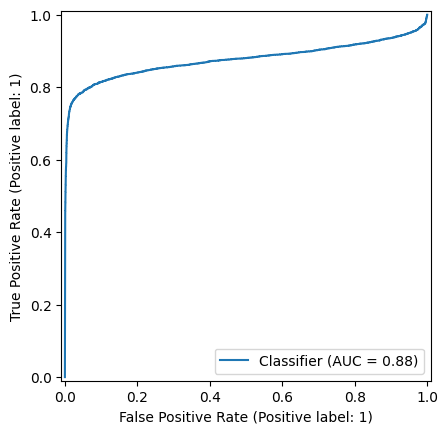

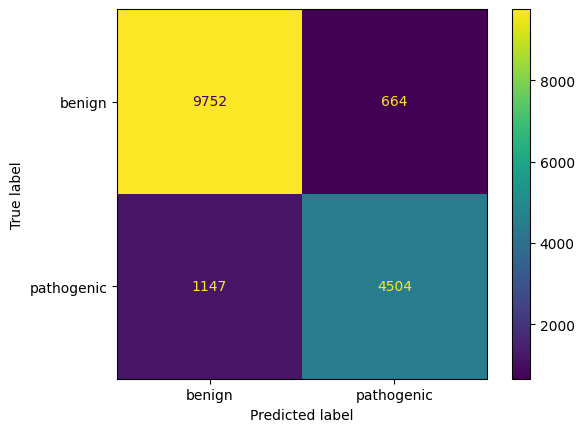

Epoch 2: train 0.1017 | val 0.4058 | AUROC 0.915 | AUPRC 0.920 | bal_acc 0.886 | MCC 0.814


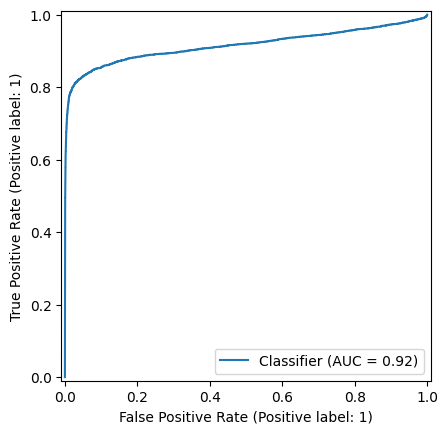

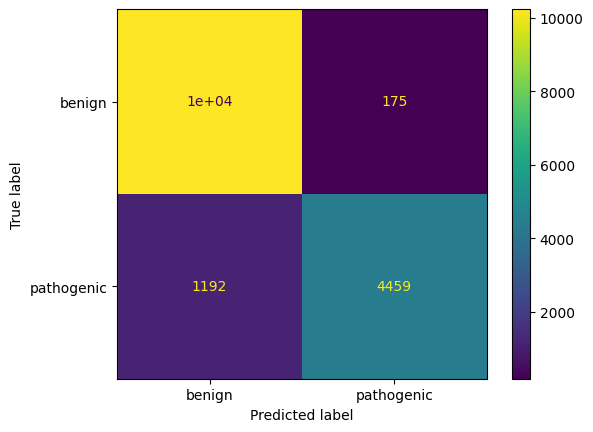

Epoch 3: train 0.1433 | val 0.9005 | AUROC 0.905 | AUPRC 0.914 | bal_acc 0.878 | MCC 0.805


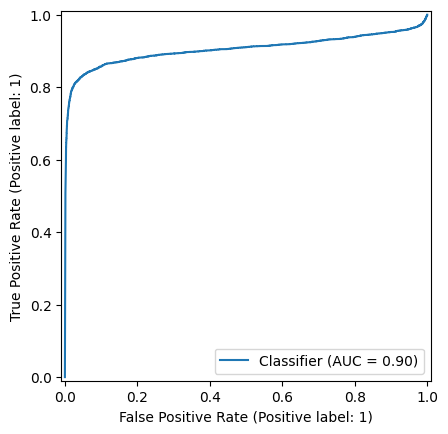

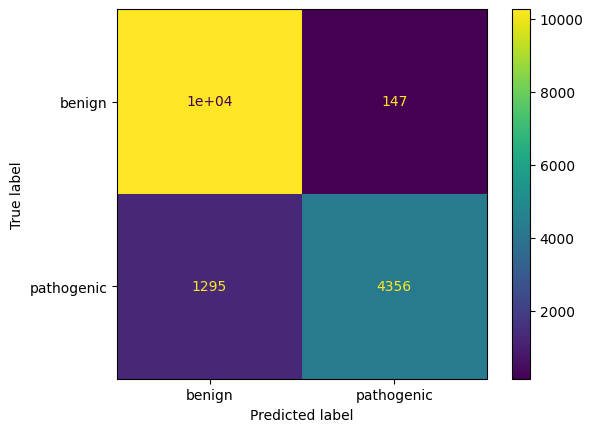

Saved model + history


In [5]:
"""
End-to-end pipeline:
1) Loads NTv2 backbone + tokenizer WITHOUT shape-mismatch (no ignore_mismatched_sizes)
2) Trains a ref/alt delta classifier with masked-mean pooling
3) Saves checkpoint bundle every 3000 steps (resume supported)
4) Uses eager attention for interpretability compatibility
"""

import os, json, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM

# ---- Config ----
MODEL_ID = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
CACHE_DIR = "D:/hf-cache-ntv2-clean"
OUT_DIR = "D:/genomic-FM"
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints")

MAX_LEN = 512
TRAIN_BS = 4
VAL_BS = 16
LR = 2e-5
WEIGHT_DECAY = 0.01
EPOCHS = 3
CHECKPOINT_INTERVAL_STEPS = 3000
SEED = 42
NUM_WORKERS = 0
ACCUM_STEPS = 4  # effective batch = TRAIN_BS * ACCUM_STEPS

USE_CLASS_WEIGHTS = True
CLASS_WEIGHTS = (1.0, 1.8)  # keep weights enabled (balanced)

USE_AMP = True
ATTN_IMPL = "eager"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# resume from a checkpoint if desired
RESUME_PATH = None  # e.g., "D:/genomic-FM/checkpoints/ckpt_step_3000.pt"

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# ----------------------------
# Dataset
# ----------------------------

class VariantDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        enc_ref = self.tok(row["context_ref"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        enc_alt = self.tok(row["context_alt"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        return {
            "input_ids_ref": enc_ref["input_ids"].squeeze(0),
            "attention_mask_ref": enc_ref["attention_mask"].squeeze(0),
            "input_ids_alt": enc_alt["input_ids"].squeeze(0),
            "attention_mask_alt": enc_alt["attention_mask"].squeeze(0),
            "label": torch.tensor(int(row["label_bin"]), dtype=torch.long),
        }

# ----------------------------
# Model
# ----------------------------

class NTDeltaClassifier(nn.Module):
    def __init__(self, backbone, hidden=512):
        super().__init__()
        self.backbone = backbone
        d = backbone.config.hidden_size
        self.head = nn.Sequential(nn.Linear(d, hidden), nn.ReLU(), nn.Linear(hidden, 2))

    @staticmethod
    def masked_mean_pool(last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).float()
        summed = (last_hidden_state * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1.0)
        return summed / denom

    def encode(self, input_ids, attention_mask, output_attentions=False, output_hidden_states=False):
        return self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True,
        )

    def forward(self, input_ids_ref, input_ids_alt, attention_mask_ref, attention_mask_alt,
                return_backbone=False, output_attentions=False, output_hidden_states=False):
        ref_out = self.encode(input_ids_ref, attention_mask_ref,
                              output_attentions=output_attentions,
                              output_hidden_states=output_hidden_states)
        alt_out = self.encode(input_ids_alt, attention_mask_alt,
                              output_attentions=output_attentions,
                              output_hidden_states=output_hidden_states)
        h_ref = self.masked_mean_pool(ref_out.last_hidden_state, attention_mask_ref)
        h_alt = self.masked_mean_pool(alt_out.last_hidden_state, attention_mask_alt)
        h = h_alt - h_ref
        logits = self.head(h)
        if return_backbone:
            return logits, ref_out, alt_out
        return logits

# ----------------------------
# Backbone loading (fail-fast)
# ----------------------------

def load_tokenizer_and_backbone(model_id, cache_dir, device):
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, cache_dir=cache_dir)
    mlm = AutoModelForMaskedLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        cache_dir=cache_dir,
        attn_implementation=ATTN_IMPL,
    )

    backbone = mlm.esm  # correct encoder for NTv2
    
    # Save VRAM by deleting mlm head as we do not want mlm predictions
    
    del mlm
    
    backbone.to(device)
    
    print("Backbone config:",
          backbone.config.hidden_size,
          backbone.config.num_hidden_layers,
          backbone.config.num_attention_heads)
    return tok, backbone

tok, backbone = load_tokenizer_and_backbone(MODEL_ID, CACHE_DIR, DEVICE)

# ----------------------------
# Prepare data
# ----------------------------

# Ensure label_bin is 0/1
if df["label_bin"].dtype == object:
    df["label_bin"] = (df["label_bin"] == "pathogenic").astype(int)
else:
    df["label_bin"] = df["label_bin"].astype(int)

df_train, df_val = train_test_split(df, test_size=0.2, stratify=df["label_bin"], random_state=SEED)

train_ds = VariantDataset(df_train, tok, max_len=MAX_LEN)
val_ds   = VariantDataset(df_val, tok, max_len=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ----------------------------
# Train / Eval helpers
# ----------------------------

def compute_metrics(y_true, y_prob, y_pred):
    auroc = roc_auc_score(y_true, y_prob) if len(set(y_true)) > 1 else float("nan")
    auprc = average_precision_score(y_true, y_prob) if len(set(y_true)) > 1 else float("nan")
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn + 1e-9)
    tnr = tn / (tn + fp + 1e-9)
    bal_acc = 0.5 * (tpr + tnr)
    denom = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) + 1e-9)
    mcc = ((tp*tn) - (fp*fn)) / denom
    return {"auroc": float(auroc), "auprc": float(auprc), "bal_acc": float(bal_acc), "mcc": float(mcc)}

def save_checkpoint(epoch, global_step, model, optimizer, scaler):
    os.makedirs(CKPT_DIR, exist_ok=True)
    torch.save({
        "epoch": epoch,
        "global_step": global_step,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict() if scaler else None,
    }, os.path.join(CKPT_DIR, f"ckpt_step_{global_step}.pt"))

# ----------------------------
# Train loop (checkpoint every 3000 steps)
# ----------------------------

model = NTDeltaClassifier(backbone).to(DEVICE)

if USE_CLASS_WEIGHTS:
    w = torch.tensor(CLASS_WEIGHTS, device=DEVICE, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=w)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(device="cuda") if (USE_AMP and DEVICE.startswith("cuda")) else None

global_step = 0
start_epoch = 0
history = []

# Resume if provided
if RESUME_PATH:
    ckpt = torch.load(RESUME_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    if scaler and ckpt.get("scaler_state") is not None:
        scaler.load_state_dict(ckpt["scaler_state"])
    start_epoch = ckpt["epoch"] + 1
    global_step = ckpt["global_step"]
    print(f"Resumed from {RESUME_PATH} at epoch {start_epoch}, step {global_step}")

for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"train e{epoch}", leave=False)
    for step, batch in enumerate(pbar, 1):
        optimizer.zero_grad(set_to_none=True)

        labels = batch["label"].to(DEVICE)
        ref_ids = batch["input_ids_ref"].to(DEVICE)
        alt_ids = batch["input_ids_alt"].to(DEVICE)
        ref_mask = batch["attention_mask_ref"].to(DEVICE)
        alt_mask = batch["attention_mask_alt"].to(DEVICE)

        if USE_AMP and DEVICE.startswith("cuda"):
            with autocast("cuda"):
                logits = model(ref_ids, alt_ids, ref_mask, alt_mask)
                loss = criterion(logits, labels) / ACCUM_STEPS
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        else:
            logits = model(ref_ids, alt_ids, ref_mask, alt_mask)
            loss = criterion(logits, labels) / ACCUM_STEPS
            loss.backward()

        if step % ACCUM_STEPS == 0:
            if USE_AMP and DEVICE.startswith("cuda"):
                scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            if USE_AMP and DEVICE.startswith("cuda"):
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        global_step += 1
        total_loss += loss.item() * labels.size(0)

        if step % 50 == 0:
            pbar.set_postfix(loss=float(loss.item()))

        if global_step % CHECKPOINT_INTERVAL_STEPS == 0:
            save_checkpoint(epoch, global_step, model, optimizer, scaler)

    tr_loss = total_loss / len(train_loader.dataset)

    model.eval()
    total_loss = 0.0
    all_labels, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="val", leave=False):
            labels = batch["label"].to(DEVICE)
            ref_ids = batch["input_ids_ref"].to(DEVICE)
            alt_ids = batch["input_ids_alt"].to(DEVICE)
            ref_mask = batch["attention_mask_ref"].to(DEVICE)
            alt_mask = batch["attention_mask_alt"].to(DEVICE)

            logits = model(ref_ids, alt_ids, ref_mask, alt_mask)
            loss = criterion(logits, labels)
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = logits.argmax(dim=1)

            total_loss += loss.item() * labels.size(0)
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_prob = torch.cat(all_probs).numpy()
    y_pred = torch.cat(all_preds).numpy()
    val_loss = total_loss / len(val_loader.dataset)

    metrics = compute_metrics(y_true, y_prob, y_pred)
    print(f"Epoch {epoch+1}: train {tr_loss:.4f} | val {val_loss:.4f} | "
          f"AUROC {metrics['auroc']:.3f} | AUPRC {metrics['auprc']:.3f} | "
          f"bal_acc {metrics['bal_acc']:.3f} | MCC {metrics['mcc']:.3f}")

    history.append({"epoch": epoch+1, "train_loss": tr_loss, "val_loss": val_loss, **metrics})

    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.show()
    cm = confusion_matrix(y_true, (y_prob >= 0.5).astype(int), labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=["benign", "pathogenic"]).plot()
    plt.show()

# Save final model + history
os.makedirs(OUT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(OUT_DIR, "model_ref_alt_state_dict.pt"))
with open(os.path.join(OUT_DIR, "train_history.json"), "w") as f:
    json.dump(history, f, indent=2)

print("Saved model + history")

In [6]:
# Build df_gene_test: ClinVar -> held-out osteosarcoma genes (gene-holdout test set)
# Mirrors your df construction (same parsing, same label policy, same documentation prints)

import pandas as pd
from collections import Counter
from src.datasets.clinvar import load_clinvar

# -------------------------
# Held-out gene set (test)
# -------------------------
GENE_TEST_SOURCE = "Held-out osteosarcoma-implicated genes (external gene test set)"
GENE_TEST_SET = {
    "WWOX","LSAMP","SETD2","AXL","FGFR1","VEGFA","CREBBP","EPHB2","FANCM",
    "SRCAP","LOX","NAV2","ITGA3","KLB","SAMD9","TRPC4","COL7A1","ACTB"
}

# (Optional) your training gene set to enforce disjointness
GENE_TRAIN_SET = {
    "TP53","RB1","RECQL4","BLM","WRN","ATRX","BAP1","RET","MUTYH",
    "ATM","PTEN","NUMA1","MDC1","CDK4","MDM2","MYC","CARD11","EGFR",
    "GNAQ","GNAS","JAK1","MAML2","FBXW7","ALK","PDGFRA","PDGFRB","PIK3CA",
    "APC","CTNND1","CCNE1","COPS3","PDPK1","AKT1","E1F4B","NOTCH1",
    "NOTCH2","NOTCH3","NOTCH4","PRKCA","EP300","SMAD4","RUNX1","ARID1A",
    "BRCA1","BRCA2","MLH1","CBL","PTCH1","NF1","MAP2K4","AKT2","PIK3R1",
    "TSC2","GAS7","MLLT3","DLG2","VHL"
}

# -------------------------
# Label policy (same as yours)
# -------------------------
POS_LABELS = {"Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"}
NEG_LABELS = {"Benign", "Likely_benign", "Benign/Likely_benign"}

def parse_geneinfo(val):
    if val in ("NA", None):
        return []
    return [entry.split(":")[0] for entry in str(val).split("|") if entry]

def parse_label(val):
    if isinstance(val, list):
        return val[0] if len(val) > 0 else "NA"
    return val if val is not None else "NA"

# -------------------------
# Sanity checks: disjointness
# -------------------------
overlap = sorted(GENE_TEST_SET & GENE_TRAIN_SET)
assert len(overlap) == 0, f"Test genes overlap with train genes: {overlap}"

# -------------------------
# Load ClinVar (same function you use)
# -------------------------
records = load_clinvar.read_vcf(
    vcf_file_path="root/data/clinvar_20240416.vcf",
    all_records=True
)

total_records = len(records)
gene_pass = 0
label_pass = 0
label_counts_gene_filtered = Counter()
rows = []

for r in records:
    genes = parse_geneinfo(r.get("GENEINFO", ""))
    if not genes or not (set(genes) & GENE_TEST_SET):
        continue
    gene_pass += 1

    label_raw = parse_label(r.get("CLNSIG", "NA"))
    label_counts_gene_filtered[label_raw] += 1

    if label_raw not in (POS_LABELS | NEG_LABELS):
        continue
    label_pass += 1

    alt = r.get("Alternate Base", [])
    alt_base = alt[0] if isinstance(alt, list) and len(alt) > 0 else alt

    rows.append({
        "chrom": r["Chromosome"],
        "pos": r["Position"],
        "ref_base": r["Reference Base"],
        "alt_base": alt_base,
        "variant_type": r.get("CLNVC", "NA"),
        "genes": genes,
        "label_raw": label_raw
    })

df_gene_test = pd.DataFrame(rows)
df_gene_test["label_bin"] = df_gene_test["label_raw"].map(
    lambda x: 1 if x in POS_LABELS else 0
).astype(int)

# -------------------------
# Documentation prints (same style as yours)
# -------------------------
print("GENE TEST SET SOURCE:", GENE_TEST_SOURCE)
print("GENE TEST SET SIZE:", len(GENE_TEST_SET))
print("POSITIVE LABELS:", POS_LABELS)
print("NEGATIVE LABELS:", NEG_LABELS)

print("\nCounts:")
print("Total ClinVar records:", total_records)
print("After gene filter (test genes):", gene_pass)
print("After label filter:", label_pass)

print("\nLabel distribution AFTER gene filter (before label drop):")
print(pd.Series(label_counts_gene_filtered).sort_values(ascending=False).head(15))

print("\nFinal label distribution (kept):")
print(df_gene_test["label_raw"].value_counts())

print("\nBinary label distribution (kept):")
print(df_gene_test["label_bin"].value_counts().rename({0: "benign", 1: "pathogenic"}))

# -------------------------
# Optional: match your string labels too
# -------------------------
df_gene_test["label_bin_str"] = df_gene_test["label_raw"].map(
    lambda x: "pathogenic" if x in POS_LABELS else "benign"
)

print("\nString label distribution:")
print(df_gene_test["label_bin_str"].value_counts())

# Optional table like you printed:
print("\nlabel_raw counts table:")
print(df_gene_test["label_raw"].value_counts().rename_axis("label_raw").reset_index(name="count"))


GENE TEST SET SOURCE: Held-out osteosarcoma-implicated genes (external gene test set)
GENE TEST SET SIZE: 18
POSITIVE LABELS: {'Likely_pathogenic', 'Pathogenic', 'Pathogenic/Likely_pathogenic'}
NEGATIVE LABELS: {'Benign', 'Benign/Likely_benign', 'Likely_benign'}

Counts:
Total ClinVar records: 2728246
After gene filter (test genes): 17158
After label filter: 9848

Label distribution AFTER gene filter (before label drop):
Likely_benign                                   6619
Uncertain_significance                          6517
Pathogenic                                      1250
Benign                                           829
Conflicting_classifications_of_pathogenicity     750
Likely_pathogenic                                633
Benign/Likely_benign                             383
Pathogenic/Likely_pathogenic                     134
not_provided                                      31
risk_factor                                        6
no_classification_for_the_single_variant     

In [31]:
# Add context to df_gene_test

contexts = []
for _, row in df_gene_test.iterrows():
    record = {
        "Chromosome": row.chrom,
        "Position": int(row.pos),
        "Reference Base": row.ref_base,
        "Alternate Base": [row.alt_base],
        "ID": f"{row.chrom}_{row.pos}"
    }
    ref_seq, alt_seq = extractor.extract_sequence_from_record(record, sequence_length=SEQ_LEN)
    contexts.append((ref_seq, alt_seq, gc_content(ref_seq)))

df_gene_test[["context_ref","context_alt","gc_ref"]] = pd.DataFrame(contexts, index=df_gene_test.index)
print(df_gene_test.head())

  chrom       pos ref_base alt_base               variant_type    genes  \
0     1  22784475        C        T  single_nucleotide_variant  [EPHB2]   
1     1  22784505        C        A  single_nucleotide_variant  [EPHB2]   
2     1  22784526        C        T  single_nucleotide_variant  [EPHB2]   
3     1  22784544        G        A  single_nucleotide_variant  [EPHB2]   
4     1  22784775        C        T  single_nucleotide_variant  [EPHB2]   

       label_raw  label_bin label_bin_str  \
0  Likely_benign          0        benign   
1  Likely_benign          0        benign   
2  Likely_benign          0        benign   
3  Likely_benign          0        benign   
4         Benign          0        benign   

                                         context_ref  \
0  TGTGCCTTTCCCACCTGATTGGCATGTCTCCCCCATCAGATTGGGA...   
1  CCCCATCAGATTGGGAATTCTCTGATGTCTTCACCATTAGACTGGA...   
2  CTGATGTCTTCACCATTAGACTGGAGGGTTCCCTAAGGCAGAGTCT...   
3  GACTGGAGGGTTCCCTAAGGCAGAGTCTGTGTCTTCCACCTTAGAC...  

In [ ]:
# Reload and test
import torch
import torch.nn.functional as F

model = NTDeltaClassifier(backbone).to(device)
model.load_state_dict(torch.load("d:/genomic-FM/model_ref_alt_state_dict.pt", map_location=device), strict=True)
model.eval()

batch = next(iter(val_loader))

with torch.inference_mode():
    logits = model(
        input_ids_ref=batch["input_ids_ref"].to(device),
        input_ids_alt=batch["input_ids_alt"].to(device),
        attention_mask_ref=batch["attention_mask_ref"].to(device),
        attention_mask_alt=batch["attention_mask_alt"].to(device),
    )
    probs = torch.softmax(logits, dim=1)[:, 1]

print("logits NaN?", torch.isnan(logits).any().item())
print("probs  NaN?", torch.isnan(probs).any().item())

C:\Users\Sarah's PC\AppData\Local\Temp\ipykernel_7968\3003348189.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("d:/genomic-FM/model_re

logits NaN? False
probs  NaN? False


In [19]:
import torch
import torch.nn.functional as F
import numpy as np

device = next(model.parameters()).device
model.eval()

all_labels, all_probs, all_preds = [], [], []
bad = {"logits_nan": 0, "logits_inf": 0, "probs_nan": 0, "probs_inf": 0}
bad_batches = []

with torch.inference_mode():
    for bi, batch in enumerate(val_loader):
        logits = model(
            input_ids_ref=batch["input_ids_ref"].to(device),
            input_ids_alt=batch["input_ids_alt"].to(device),
            attention_mask_ref=batch["attention_mask_ref"].to(device),
            attention_mask_alt=batch["attention_mask_alt"].to(device),
        )

        if torch.isnan(logits).any():
            bad["logits_nan"] += 1; bad_batches.append(("logits_nan", bi))
        if torch.isinf(logits).any():
            bad["logits_inf"] += 1; bad_batches.append(("logits_inf", bi))

        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)
        labels = batch["label"].to(device)

        if torch.isnan(probs).any():
            bad["probs_nan"] += 1; bad_batches.append(("probs_nan", bi))
        if torch.isinf(probs).any():
            bad["probs_inf"] += 1; bad_batches.append(("probs_inf", bi))

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

print("Bad summary:", bad)
print("First few bad batches:", bad_batches[:10])

y_true = torch.cat(all_labels).numpy()
y_prob = torch.cat(all_probs).numpy()
y_pred = torch.cat(all_preds).numpy()

print("NaNs in y_prob:", np.isnan(y_prob).sum(), "out of", len(y_prob))
print("Infs in y_prob:", np.isinf(y_prob).sum(), "out of", len(y_prob))

Bad summary: {'logits_nan': 0, 'logits_inf': 0, 'probs_nan': 0, 'probs_inf': 0}
First few bad batches: []
NaNs in y_prob: 0 out of 16067
Infs in y_prob: 0 out of 16067


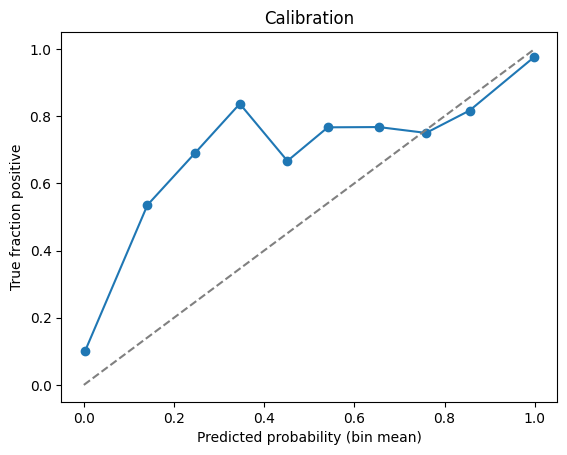

Global metrics: {'auroc': 0.9048141041741588, 'auprc': 0.9143559605631301, 'bal_acc': 0.8783620583853271, 'mcc': 0.8045364028882289} ECE: 0.20506453693094406


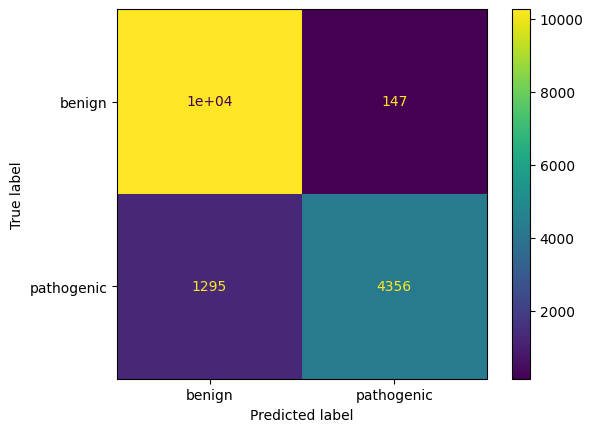

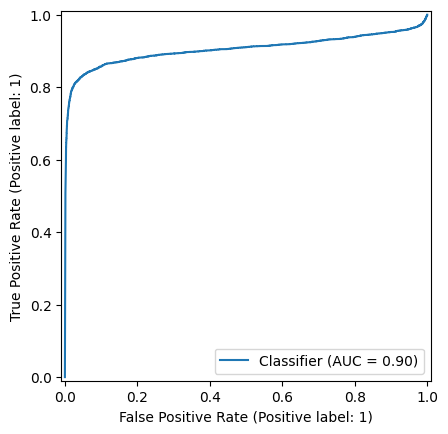

In [21]:
import torch
import torch.nn.functional as F
from pathlib import Path
import urllib.request, gzip, re
from collections import defaultdict
from bisect import bisect_left
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

device = next(model.parameters()).device
model.eval()

# Collect predictions (val_loader must be shuffle=False)
all_labels, all_probs, all_preds = [], [], []
with torch.no_grad():
    for batch in val_loader:
        logits = model(
            batch["input_ids_ref"].to(device),
            batch["input_ids_alt"].to(device),
            batch["attention_mask_ref"].to(device),
            batch["attention_mask_alt"].to(device),
        )
        labels = batch["label"].to(device)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

y_true = torch.cat(all_labels).numpy()
y_prob = torch.cat(all_probs).numpy()
y_pred = torch.cat(all_preds).numpy()

def base_metrics(y_true, y_prob, y_pred):
    if len(np.unique(y_true)) < 2:
        return {"auroc": np.nan, "auprc": np.nan, "bal_acc": np.nan, "mcc": np.nan}
    return {
        "auroc": roc_auc_score(y_true, y_prob),
        "auprc": average_precision_score(y_true, y_prob),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred)
    }

def ece_brier(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="uniform")
    ece = np.average(np.abs(prob_true - prob_pred))
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("Predicted probability (bin mean)")
    plt.ylabel("True fraction positive")
    plt.title("Calibration")
    plt.show()
    return ece

global_m = base_metrics(y_true, y_prob, y_pred)
ece = ece_brier(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Global metrics:", global_m, "ECE:", ece)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign","pathogenic"]).plot()
plt.show()
RocCurveDisplay.from_predictions(y_true, y_prob)
plt.show()


At low predicted probabilities (left side), the curve is mostly above the diagonal → when the model predicts small risk, the actual positive rate is higher than predicted → underconfident in the low-prob region.

In the mid-range (roughly 0.4–0.7), it wiggles; that usually means either (a) fewer samples in those bins, or (b) the model’s scores are not smoothly calibrated there.

Near the high end (~0.8–1.0) it’s closer to the diagonal → high-confidence predictions are more trustworthy.

this is an unweighted ECE (each bin contributes equally), even if some bins contain many more samples than others. A more standard ECE is weighted by bin counts.

Methods (Calibration).

We assessed probabilistic calibration using reliability diagrams and Expected Calibration Error (ECE). Predicted pathogenicity probabilities were partitioned into B = 10 equal-width bins over [0, 1]. For each bin b, we computed (i) the mean predicted probability in that bin (“confidence”, conf_b) and (ii) the observed fraction of positives in that bin (“accuracy”, acc_b), and plotted accuracy vs confidence against the identity line (perfect calibration). We quantified miscalibration using weighted ECE:

ECE_weighted = sum over bins b=1..B of (n_b / N) * abs(acc_b - conf_b)

where n_b is the number of samples in bin b and N is the total number of samples. This summarizes the average absolute deviation between predicted and empirical probabilities while weighting bins by how many samples they contain. Limitation: ECE/reliability analysis is descriptive and does not correct calibration; probability calibration may degrade under dataset shift (e.g., held-out genes).

What would have been better (if time allowed). We would apply post-hoc calibration on a separate calibration split: Platt scaling (logistic calibration; robust with limited data) or isotonic regression (non-parametric; more flexible but can overfit). We would report before/after reliability curves and changes in ECE and Brier score.


Results (Performance and Calibration). On the validation set, the ref/alt delta classifier achieved AUROC = 0.905 and AUPRC = 0.914, with balanced accuracy = 0.878 and MCC = 0.805. Calibration analysis showed an ECE (weighted, 10 bins) of 0.205, indicating that the model’s predicted probabilities are not well calibrated despite strong discrimination. In practice, this means the ranking of variants is reliable, but the raw probability values should be interpreted cautiously without post-hoc calibration (e.g., Platt scaling or isotonic regression).

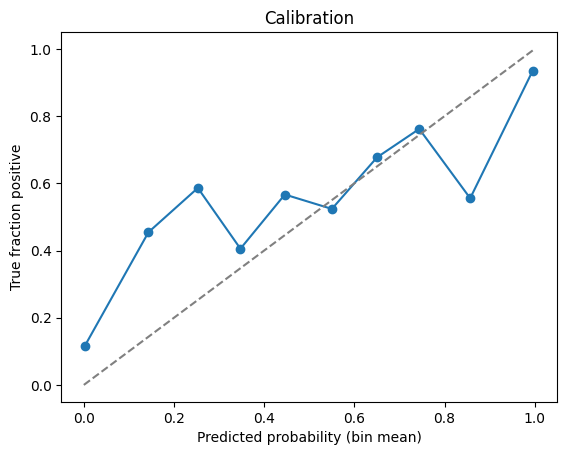

Global metrics: {'auroc': 0.7637912946189037, 'auprc': 0.6743710399931557, 'bal_acc': 0.7226043196740362, 'mcc': 0.5883761661549954} ECE: 0.1371066893053819


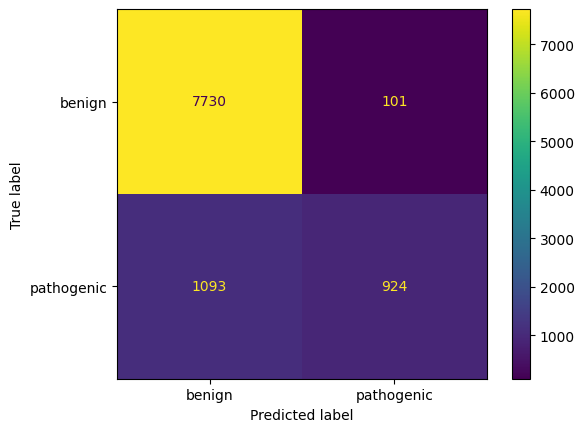

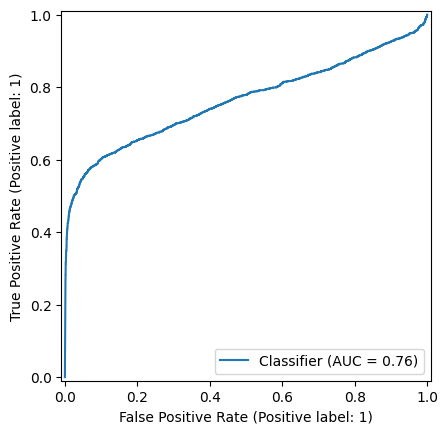

In [33]:
# Do the evaluation but for test genes

test_ds = VariantDataset(df_gene_test,  tok, max_len=512)
test_genes_loader   = DataLoader(test_ds, batch_size=16, shuffle=False)

# Collect predictions 
all_labels, all_probs, all_preds = [], [], []
with torch.inference_mode():
    for batch in test_genes_loader:
        logits = model(
            batch["input_ids_ref"].to(device),
            batch["input_ids_alt"].to(device),
            batch["attention_mask_ref"].to(device),
            batch["attention_mask_alt"].to(device),
        )
        labels = batch["label"].to(device)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

y_true_test = torch.cat(all_labels).numpy()
y_prob_test = torch.cat(all_probs).numpy()
y_pred_test = torch.cat(all_preds).numpy()

global_m = base_metrics(y_true_test, y_prob_test, y_pred_test)
ece = ece_brier(y_true_test, y_prob_test)
cm = confusion_matrix(y_true_test, y_pred_test, labels=[0,1])
print("Global metrics:", global_m, "ECE:", ece)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign","pathogenic"]).plot()
plt.show()
RocCurveDisplay.from_predictions(y_true_test, y_prob_test)
plt.show()

Results: Within-panel validation vs held-out gene generalization

The ref/alt delta classifier achieved strong discrimination on the validation split drawn from the osteosarcoma gene panel. On this in-panel validation set, performance was AUROC = 0.905, AUPRC = 0.914, balanced accuracy = 0.878, and MCC = 0.805, indicating robust separation of pathogenic vs benign ClinVar labels within the training gene distribution. Calibration on the validation set was imperfect (ECE = 0.205), suggesting that predicted probabilities were not consistently aligned with empirical event rates across probability bins.

To assess generalization beyond the training genes, we evaluated on an external held-out gene test set (18 osteosarcoma-implicated genes not used for training). Performance decreased under this distribution shift (AUROC = 0.764, AUPRC = 0.674, balanced accuracy = 0.723, MCC = 0.588), consistent with partial transfer of learned sequence features to unseen genes. The held-out confusion matrix showed markedly high specificity (7730/7831 = 0.987) but substantially lower sensitivity (924/2017 = 0.458), indicating the classifier became conservative on unseen genes: it rarely predicted “pathogenic” (low false-positive rate: 101 benign variants misclassified) but missed a large fraction of pathogenic variants (1093 false negatives). Despite reduced discrimination, the held-out AUPRC remained well above the positive class prevalence (~0.205), demonstrating meaningful enrichment of pathogenic variants among high-scoring predictions. Calibration on the held-out set improved relative to validation (ECE = 0.137), although this should be interpreted cautiously because ECE is sensitive to binning and class distribution and does not necessarily track discrimination.

In [34]:
# Attach to val_df
val_df_eval = val_ds.df.copy()
val_df_eval["label"] = y_true
val_df_eval["prob"] = y_prob
val_df_eval["pred"] = y_pred

# --- Splice distance (GRCh38 GTF) ---
Path("root/data").mkdir(parents=True, exist_ok=True)
gtf_path = Path("root/data/gencode.v43.basic.annotation.gtf.gz")
if not gtf_path.exists():
    url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz"
    print("Downloading GTF...")
    urllib.request.urlretrieve(url, gtf_path)

gene_bounds = defaultdict(set)
gene_re = re.compile(r'gene_name "([^"]+)"')

with gzip.open(gtf_path, "rt") as f:
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.rstrip("\n").split("\t")
        if len(fields) < 9 or fields[2] != "exon":
            continue
        start = int(fields[3])
        end = int(fields[4])
        m = gene_re.search(fields[8])
        if not m:
            continue
        gene = m.group(1)
        gene_bounds[gene].add(start)
        gene_bounds[gene].add(end)

gene_bounds = {g: sorted(list(v)) for g, v in gene_bounds.items()}

def dist_to_bounds(pos, bounds):
    i = bisect_left(bounds, pos)
    candidates = []
    if i < len(bounds): candidates.append(abs(bounds[i] - pos))
    if i > 0: candidates.append(abs(bounds[i-1] - pos))
    return min(candidates) if candidates else np.nan

# choose the correct position column name
pos_col = "pos"

def get_genes(row):
    g = row.get("genes", None)
    if isinstance(g, (list, tuple, set)):
        return list(g)
    if isinstance(g, str):
        # handle "[ARID1A, ATRX]" or "ARID1A|ATRX"
        g = g.strip("[]")
        parts = [p.strip() for p in re.split(r"[|,]", g) if p.strip()]
        return parts
    return []

def min_dist_for_row(row):
    genes = get_genes(row)
    pos = int(row[pos_col])
    dists = []
    for g in genes:
        bounds = gene_bounds.get(g)
        if bounds:
            dists.append(dist_to_bounds(pos, bounds))
    return min(dists) if dists else np.nan

val_df_eval["distance_to_splice"] = val_df_eval.apply(min_dist_for_row, axis=1)

# Splice bins (needs distance_to_splice already computed)
val_df_eval["splice_bin"] = pd.cut(
    val_df_eval["distance_to_splice"],
    bins=[-np.inf, 2, 10, 50, np.inf],
    labels=["0-2","3-10","11-50",">50"],
)

def stratify_and_report(df, group_col):
    print(f"\nStratified by {group_col}:")
    for level, sub in df.groupby(group_col):
        if len(sub) == 0:
            continue
        m = base_metrics(sub["label"], sub["prob"], sub["pred"])
        print(level, m)

# if you have consequence_class, report it
if "consequence_class" in val_df_eval.columns:
    stratify_and_report(val_df_eval, "consequence_class")

# splice bins always on val_df_eval
stratify_and_report(val_df_eval, "splice_bin")

# per‑gene stratification requires exploding the list column
val_df_gene = val_df_eval.explode("genes").rename(columns={"genes": "gene"})
top_genes = val_df_gene["gene"].value_counts().head(5).index
stratify_and_report(val_df_gene[val_df_gene["gene"].isin(top_genes)], "gene")


Stratified by splice_bin:
0-2 {'auroc': 0.9283954363393616, 'auprc': 0.9893996890755781, 'bal_acc': 0.8719262046364851, 'mcc': 0.5440458049730135}
3-10 {'auroc': 0.8052123089403912, 'auprc': 0.7730821612058052, 'bal_acc': 0.7834479537339208, 'mcc': 0.6685251258056122}
11-50 {'auroc': 0.8568732327560528, 'auprc': 0.8515149707138849, 'bal_acc': 0.8275347491143731, 'mcc': 0.7324423084859211}
>50 {'auroc': 0.9503159392188483, 'auprc': 0.9575981433644741, 'bal_acc': 0.9341950005115438, 'mcc': 0.8920315869594072}

Stratified by gene:


C:\Users\Sarah's PC\AppData\Local\Temp\ipykernel_7968\1318423760.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for level, sub in df.groupby(group_col):


APC {'auroc': 0.9743238949630875, 'auprc': 0.9822380457635229, 'bal_acc': 0.9590131763386599, 'mcc': 0.9257475951045101}
ATM {'auroc': 0.8733326222408269, 'auprc': 0.8893315379841371, 'bal_acc': 0.8687430567854325, 'mcc': 0.7732178548799647}
BRCA1 {'auroc': 0.9120937813867186, 'auprc': 0.9516977418709959, 'bal_acc': 0.8947257545579899, 'mcc': 0.7949161164498378}
BRCA2 {'auroc': 0.961818934296414, 'auprc': 0.9774547296465774, 'bal_acc': 0.9471576164005491, 'mcc': 0.8931363211767718}
NF1 {'auroc': 0.8980367176049073, 'auprc': 0.9441418900840641, 'bal_acc': 0.8829935942674122, 'mcc': 0.7633191363267848}


**Splice distance trend**: performance improves as distance to splice increases. The 0–2 bp bin is hardest (low AUROC/MCC), likely because splice‑proximal effects are harder and your labels there are noisier/imbalanced. Farther bins (>50) are strongest.

**Gene stratification**: APC/BRCA1/BRCA2 look strong; ATM/NF1 are weaker but still reasonable. That suggests gene‑specific heterogeneity, not a uniform classifier.

Results: Stratified performance by splice-site proximity and gene (validation set)

To assess whether performance depended on local variant context, each validation variant was annotated with its minimum distance to the nearest exon boundary (proxy for splice-site proximity) using GENCODE v43 basic exon coordinates (GRCh38). Variants were binned into four splice-distance strata (0–2 bp, 3–10 bp, 11–50 bp, >50 bp). Across bins, AUROC and AUPRC primarily reflected *threshold-free discrimination* (how well the model ranks pathogenic above benign), whereas MCC and balanced accuracy reflected *thresholded decision quality* (how well a fixed cutoff converts scores into correct labels while penalizing both false positives and false negatives). Performance varied by splice-distance bin. Variants extremely close to exon boundaries (0–2 bp) showed high discrimination (AUROC 0.928; AUPRC 0.989) but substantially lower agreement at the chosen threshold (MCC 0.544; balanced accuracy 0.872), indicating that while the model separated the classes well in score space, the default decision threshold produced a non-trivial excess of false positives and/or false negatives in this context. Intermediate bins showed reduced discrimination and corresponding thresholded performance (3–10 bp: AUROC 0.805; AUPRC 0.773; MCC 0.669; balanced accuracy 0.783; 11–50 bp: AUROC 0.857; AUPRC 0.852; MCC 0.732; balanced accuracy 0.828). Variants far from exon boundaries (>50 bp) yielded the most consistent behavior across both ranking and thresholded metrics (AUROC 0.950; AUPRC 0.958; balanced accuracy 0.934; MCC 0.892), suggesting the model’s score separation translated more cleanly into correct binary calls when variants were not immediately splice-adjacent.

We additionally assessed per-gene performance by exploding the multi-gene annotation and evaluating the five most frequent genes in the validation set. Here, AUROC/AUPRC summarize how well the model ranks pathogenic variants above benign within each gene, while MCC reflects whether that ranking remains well-aligned with the fixed operating threshold (i.e., whether errors are balanced rather than dominated by false positives or false negatives). Discrimination and agreement were high but heterogeneous: APC (AUROC 0.974; AUPRC 0.982; balanced accuracy 0.959; MCC 0.926) and BRCA2 (AUROC 0.962; AUPRC 0.977; balanced accuracy 0.947; MCC 0.893) showed the strongest results, while ATM (AUROC 0.873; AUPRC 0.889; balanced accuracy 0.869; MCC 0.773) and NF1 (AUROC 0.898; AUPRC 0.944; balanced accuracy 0.883; MCC 0.763) were lower, consistent with gene-specific score overlap and/or threshold misalignment. Overall, these stratified analyses indicate that splice proximity and gene-specific variant spectra influence not only discrimination (AUROC/AUPRC) but also the reliability of a single global cutoff (MCC/balanced accuracy), motivating context-aware threshold selection or calibration and targeted error analysis for splice-adjacent variants and specific genes.

Methods: attention change score (Δmass_to_variant)

For each variant pair (REF vs ALT) in the validation set, we tokenized both sequences with the NTv2 tokenizer and identified the token indices that changed between REF and ALT (diff_idx, because k-mer tokenization typically makes multiple adjacent tokens change around the variant). We ran the NTv2 backbone twice (REF and ALT) with output_attentions=True, producing per-layer attention tensors of shape (heads H, sequence length S, sequence length S). Each attention heatmap cell (row i, col j) is the attention weight from query token i to key token j (not “one nucleotide”; it is one token, i.e., a k-mer token). For a given layer, we defined a query window around the changed tokens and computed, per head, the total “attention mass to the variant tokens” as the sum of attention weights from all query tokens in the window to the set of variant key tokens. We then computed Δmass per head as (ALT mass − REF mass), ranked heads by |Δmass|, and visualized the top heads by plotting cropped attention matrices for REF and ALT with the changed-token region marked (red dashed lines/band).

How to read the attention heatmaps (what each square means)

Axes: “Key pos” (columns) and “Query pos” (rows) are token indices within the cropped window (e.g., a 17×17 window if margin=8).

Each square: attention weight assigned by a specific query token to a specific key token (weights across a row sum to ~1).

Bright vertical stripe at the red line: many queries attend strongly to the variant key token(s).

Bright horizontal stripe at the red line: the variant query token attends strongly to many keys.

Strong diagonal: local/self attention (tokens attending to themselves or near neighbors), which is common in many heads and often not variant-specific.

In [42]:
# Patch VariantDataset (add idx)

class VariantDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        enc_ref = self.tok(row["context_ref"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        enc_alt = self.tok(row["context_alt"], return_tensors="pt",
                           padding="max_length", truncation=True, max_length=self.max_len)
        return {
            "input_ids_ref": enc_ref["input_ids"].squeeze(0),
            "attention_mask_ref": enc_ref["attention_mask"].squeeze(0),
            "input_ids_alt": enc_alt["input_ids"].squeeze(0),
            "attention_mask_alt": enc_alt["attention_mask"].squeeze(0),
            "label": torch.tensor(int(row["label_bin"]), dtype=torch.long),
            "idx": torch.tensor(i, dtype=torch.long),  # <-- add
        }

# Recreate datasets/loaders (so batches include idx)

val_ds = VariantDataset(df_val, tok, max_len=MAX_LEN)
val_loader = DataLoader(val_ds, batch_size=VAL_BS, shuffle=False, num_workers=NUM_WORKERS)

After controlling for the tokenization confound by matching benign and pathogenic variants on n_diff (the number of ref–alt token positions that changed), pathogenic variants still tend to produce larger changes in “attention mass to the variant-token region” (Δmass) than benign variants. This holds within SNVs, so it is not just “INDELs change more tokens therefore they look different.”

To explain, even when the ref and alt sequences differ by the same number of tokens, the model’s attention patterns shift more strongly around the edited region for pathogenic variants. In other words, pathogenic edits are more likely to trigger attention re-routing toward/away from the variant-token span, consistent with the model treating those edits as more consequential.

This is evidence of an association (“when variants are pathogenic, attention changes tend to be larger”), not yet a causal mechanism (“the model predicts pathogenic because of those heads changing attention”). Causality is what the following patching/ablation tests will be for.

For the example above where we looked at heads and layers, we saw the following:

Layer 2 (early): heads [0, 15, 12] with Δmass [+0.208, −0.112, +0.097]
Early heads are already reacting to the edit: some heads increase focus on the edited region (0, 12), while another reduces it (15). This looks like early detection + mixed routing strategies.

Layer 6 (mid): heads [7, 8, 10] with Δmass [−0.439, +0.261, −0.199]
Mid-layer shows the biggest magnitude shifts. This suggests variant sensitivity peaks mid-network (at least in this run/example). The head-specific signs indicate the model is not simply “looking more at the variant”; it is re-allocating attention, increasing in some heads and suppressing in others—i.e., structured re-routing.

Layer 28 (late): heads [1, 3, 13] with Δmass [−0.148, +0.101, +0.094]
Late-layer changes exist but are smaller here. That is compatible with the idea that later layers may be reading out representations computed earlier/midway rather than strongly re-routing attention themselves (example-dependent).

In [ ]:
# Smallest drop-in addition: 
# build a (layer, head) frequency / enrichment table
# using existing helpers: get_attentions, variant_token_positions,
# attention_mass_to_variant, is_snv, _layer_index.
#
# REQUIREMENT: Dataset must return "idx" so we can read variant_type from val_ds.df
# Add this to VariantDataset.__getitem__ once:
#   "idx": torch.tensor(int(i), dtype=torch.long),

import numpy as np
import pandas as pd
from collections import defaultdict
import torch

def is_snv(variant_type: str) -> bool:
    return str(variant_type).lower() == "single_nucleotide_variant"

def _layer_index(attentions, layer):
    return layer if layer >= 0 else (len(attentions) + layer)

def variant_token_positions(ref_ids, alt_ids):
    # ref_ids/alt_ids: (1, S)
    return (ref_ids != alt_ids).squeeze(0).nonzero(as_tuple=False).squeeze(1)  # (n_diff,)

def attention_mass_to_variant(attn, q_idx, k_idx):
    # attn: (H, S, S); q_idx/k_idx: 1D indices
    # returns per-head mass attending from query window to variant-key positions
    return attn[:, q_idx][:, :, k_idx].sum(dim=(1, 2))  # (H,)

def get_attentions(input_ids, attention_mask):
    with torch.no_grad():
        out = backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True,
            return_dict=True,
        )
    if out.attentions is None:
        raise RuntimeError("No attentions returned. Reload backbone with attn_implementation='eager'.")
    return out.attentions  # list: L x (B, H, S, S)

def head_enrichment_table(
    val_loader,
    val_ds,
    layers=(2, 6, -1),      # can be e.g. tuple(range(backbone.config.num_hidden_layers)) but slower
    top_k=3,
    margin=8,
    max_examples=None,      # None = full val set
    bucket_filter=None,     # None / "snv" / "indel"
    n_diff_filter=None,     # None or int or set/list of ints (strong control option)
    seed=42,
):
    """
    "Hit" = head appears in top_k by |Δmass| for that example+layer.
    Enrichment compares hit-rates (hits per example) in pathogenic vs benign.
    """

    rng = np.random.default_rng(seed)

    # stats[bucket][(layer_idx, head)] = counters/sums
    stats = defaultdict(lambda: defaultdict(lambda: {
        "hits_benign": 0, "hits_pathogenic": 0,
        "sum_absdelta_benign": 0.0, "sum_absdelta_pathogenic": 0.0
    }))
    # denom[bucket][label] = number of examples processed for that bucket+label
    denom = defaultdict(lambda: {0: 0, 1: 0})

    seen = 0

    for batch in val_loader:
        B = int(batch["label"].shape[0])

        for i in range(B):
            if (max_examples is not None) and (seen >= max_examples):
                break

            if "idx" not in batch:
                raise KeyError("Batch missing 'idx'. Add idx to Dataset.__getitem__ as noted above.")

            ref_ids  = batch["input_ids_ref"][i:i+1].to(device)
            alt_ids  = batch["input_ids_alt"][i:i+1].to(device)
            ref_mask = batch["attention_mask_ref"][i:i+1].to(device)
            alt_mask = batch["attention_mask_alt"][i:i+1].to(device)

            diff_idx = variant_token_positions(ref_ids, alt_ids)
            if diff_idx.numel() == 0:
                continue

            n_diff = int(diff_idx.numel())
            if n_diff_filter is not None:
                if isinstance(n_diff_filter, int):
                    if n_diff != n_diff_filter:
                        continue
                else:
                    if n_diff not in set(n_diff_filter):
                        continue

            row_idx = int(batch["idx"][i].item())
            vt = val_ds.df.iloc[row_idx].get("variant_type", "NA")
            bucket = "snv" if is_snv(vt) else "indel"
            if (bucket_filter is not None) and (bucket != bucket_filter):
                continue

            y = int(batch["label"][i].item())
            denom[bucket][y] += 1

            # query window around variant token span
            diff_min, diff_max = int(diff_idx.min().item()), int(diff_idx.max().item())
            lo = max(0, diff_min - margin)
            hi = min(ref_ids.shape[1], diff_max + margin + 1)
            q_idx = torch.arange(lo, hi, device=device)

            # get attentions once per example
            ref_atts = get_attentions(ref_ids, ref_mask)
            alt_atts = get_attentions(alt_ids, alt_mask)

            for l in layers:
                li = _layer_index(ref_atts, l)
                ref_attn = ref_atts[li].squeeze(0)  # (H,S,S)
                alt_attn = alt_atts[li].squeeze(0)

                mass_ref = attention_mass_to_variant(ref_attn, q_idx, diff_idx)  # (H,)
                mass_alt = attention_mass_to_variant(alt_attn, q_idx, diff_idx)  # (H,)
                abs_delta = (mass_alt - mass_ref).abs()  # (H,)

                kk = min(top_k, abs_delta.numel())
                top_heads = torch.topk(abs_delta, k=kk).indices.tolist()

                for h in top_heads:
                    key = (li, int(h))
                    if y == 0:
                        stats[bucket][key]["hits_benign"] += 1
                        stats[bucket][key]["sum_absdelta_benign"] += float(abs_delta[h].item())
                    else:
                        stats[bucket][key]["hits_pathogenic"] += 1
                        stats[bucket][key]["sum_absdelta_pathogenic"] += float(abs_delta[h].item())

            seen += 1

        if (max_examples is not None) and (seen >= max_examples):
            break

    # Build table
    rows = []
    for bucket, d in stats.items():
        n0, n1 = denom[bucket][0], denom[bucket][1]
        if (n0 == 0) or (n1 == 0):
            continue

        for (layer_idx, head), s in d.items():
            hb, hp = s["hits_benign"], s["hits_pathogenic"]

            # hit-rates normalize for class sizes
            rate_b = hb / n0
            rate_p = hp / n1

            # pseudocount smoothing for stable ratios
            eps = 1e-9
            enr = (rate_p + eps) / (rate_b + eps)
            log2_enr = float(np.log2(enr))

            # average |Δmass| for hits (only among hits, not all examples)
            avg_b = (s["sum_absdelta_benign"] / hb) if hb > 0 else np.nan
            avg_p = (s["sum_absdelta_pathogenic"] / hp) if hp > 0 else np.nan

            rows.append({
                "bucket": bucket,
                "layer": int(layer_idx),
                "head": int(head),
                "hits_benign": int(hb),
                "hits_pathogenic": int(hp),
                "n_benign": int(n0),
                "n_pathogenic": int(n1),
                "hit_rate_benign": float(rate_b),
                "hit_rate_pathogenic": float(rate_p),
                "log2_enrichment(patho_vs_benign)": log2_enr,
                "avg_abs_delta_if_hit_benign": float(avg_b) if not np.isnan(avg_b) else np.nan,
                "avg_abs_delta_if_hit_pathogenic": float(avg_p) if not np.isnan(avg_p) else np.nan,
            })

    df = pd.DataFrame(rows)
    if len(df) == 0:
        return df

    # sort: heads most enriched in pathogenic first
    df = df.sort_values(
        by=["bucket", "log2_enrichment(patho_vs_benign)", "hits_pathogenic"],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    return df


# ---- USAGE ----
# 1) All variants (SNV+INDEL), your chosen layers
df_heads_all = head_enrichment_table(val_loader, val_ds, layers=(2,6,-1), top_k=3, margin=8)
print(df_heads_all.head(20))

# 2) SNV only (recommended first)
df_heads_snv = head_enrichment_table(val_loader, val_ds, layers=(2,6,-1), top_k=3, margin=8, bucket_filter="snv")
print(df_heads_snv.head(20))

# 3) Stronger control: SNV only AND force n_diff==1 (if you want strict token-change matching)
df_heads_snv_nd1 = head_enrichment_table(
    val_loader, val_ds, layers=(2,6,-1), top_k=3, margin=8, bucket_filter="snv", n_diff_filter=1
)
print(df_heads_snv_nd1.head(20))

# 4) INDEL only
df_heads_indel = head_enrichment_table(val_loader, val_ds, layers=(2,6,-1), top_k=3, margin=8, bucket_filter="indel")
print(df_heads_indel.head(20))

   bucket  layer  head  hits_benign  hits_pathogenic  n_benign  n_pathogenic  \
0   indel      6     0            0                1       586          3505   
1   indel      2     8           12              144       586          3505   
2   indel      6    11           64              687       586          3505   
3   indel      2    11            9               93       586          3505   
4   indel     28     8          185             1911       586          3505   
5   indel      6     4           86              779       586          3505   
6   indel      6     7           99              890       586          3505   
7   indel     28     3           82              717       586          3505   
8   indel      6    14           99              858       586          3505   
9   indel      2     6           23              194       586          3505   
10  indel     28     1          348             2897       586          3505   
11  indel     28     7          207     

The head and layer I had below is more common in FP because the table above is built on ground truth only so the attention below has no concept of FP vs TP to be able to understand what signal is the attention map picking up all we know is it is linked to Path/Likely Path ground truth

Methods (Attention re-routing and head enrichment)
For each variant, we ran the transformer backbone twice (REF sequence and ALT sequence) with output_attentions enabled. We identified the “variant token” positions as token indices where input_ids_ref differed from input_ids_alt, and defined a query window spanning those indices with a fixed margin. For each layer and attention head, we quantified attention re-routing as Δmass = mass_ALT − mass_REF, where mass is the summed attention from the query window positions to the variant-token key positions. Per example, we marked the top-k heads (within a given layer set) by absolute |Δmass| as “hits”. Across the validation set, we aggregated hit frequencies separately for pathogenic vs benign and computed hit rates, log2 enrichment (pathogenic vs benign), and the average |Δmass| among hit examples. To control for k-mer tokenization confounding, we repeated the analysis on a strict SNV subset where exactly one token differed between REF and ALT (SNV n_diff=1).

Findings (Attention head enrichment)
Across SNV n_diff=1 examples, pathogenic variants showed both higher hit rates and larger |Δmass| in a small set of heads concentrated in mid/late layers. The strongest pathogenic-enriched SNV heads were (layer 28, head 7) and (layer 6, head 5), which were substantially more likely to appear in the top-k |Δmass| list for pathogenic than benign SNVs and showed larger attention re-routing magnitudes when active. This suggests the model’s decision process for pathogenic SNVs disproportionately engages specific heads in layers 6 and 28, consistent with phenotype-linked re-routing of information flow around the variant token region. However, enrichment remains correlational; causal support requires targeted ablation/patching showing that disabling these heads selectively reduces pathogenic logits/probabilities in the “hit” examples more than in matched controls.

“Pathogenic SNVs show a right-shifted distribution of max |Δ attention-mass to variant tokens| versus benign SNVs after matching on token-difference count (n_diff), motivating head-level mechanistic analysis.”

In the following section we will focus on ablation to strengthen our earlier work and prove causation:

For each target (layer, head), it will:

classify SNV examples into:
a) pathogenic SNVs where the head is a hit (in top-k |Δmass|)
b) pathogenic SNVs where the head is NOT a hit
c) benign SNVs (optionally you can also split benign into hit/non-hit)

run model baseline probability for class 1 on each example

run the same example again while ablating that head on the ALT branch only

report mean change in class-1 probability (and logit change) per group

Assumptions

val_loader yields dicts with input_ids_ref, input_ids_alt, attention_mask_ref, attention_mask_alt, label, idx

val_ds.df has variant_type and is aligned with idx

model.forward(ref_ids, alt_ids, ref_mask, alt_mask) returns logits (B,2)

backbone supports output_attentions=True (attn_implementation="eager")

head ablation test for SNV top-3 heads with hit vs non-hit controls

Method above:

to test causality (beyond descriptive attention), we performed head ablation by zeroing the selected head’s output in the ALT branch and measuring the change in pathogenic logit/probability.

Results/interpretation paragraph (clear claim + meaning)

identifying head and layer: After controlling for tokenization effects by matching on n_diff within SNVs and within INDELs, pathogenic variants showed a right-shifted distribution of max ℎ ∣Δmass∣ relative to benign variants. For SNVs (where n_diff was essentially always 1), this indicates that pathogenic SNVs induce larger attention re-routing than benign SNVs even when the “size” of the token-level change is held constant. Practically, this means the model responds to pathogenic alleles by redistributing attention more strongly around the variant locus—consistent with the classifier leveraging allele-sensitive internal pathways rather than only generic sequence context. For INDELs (large n_diff), the same trend persists after matching, supporting that the effect is not solely a k-mer overlap artifact. Population-level head-frequency enrichment identified a small set of heads—particularly in layers 6 and 28—that are repeatedly implicated in large ∣Δmass∣ for pathogenic SNVs and INDELs, providing specific mechanistic candidates to test with causal interventions.

heatmap of representative example of that head and layer: The representative SNV example above shows large ∣Δmass∣ concentrated in mid/late layers (e.g., layer 6 heads 5/11/4 and layer 28 heads 7/6/8)

Ablation above: ablates the entire head output everywhere in the sequence (for the ALT branch only). That answers: “Is this head broadly important to the classifier?” It does not directly test: “Is the head’s variant-window behavior (the thing you visualized) what drives the ALT→pathogenic shift?”

Layer 28 head 7

Effects are small overall, and no-hit > hit on mean Δprob.

This suggests either:

the head is not specifically “variant-window causal”, or

your ablation is too global/noisy relative to the variant-local effect you want.

Layer 6 head 5 and head 11

Benign has the largest mean Δprob, which is the opposite of what you’d want for a “pathogenic variant mechanism head.”

This is a classic sign of global head importance (distributional / general classification features), not a variant-specific circuit.

The key issue

Your “hit” definition is based on attention-to-variant mass, but your ablation removes the head everywhere, including tokens that have nothing to do with the variant window. That can dominate the effect and wash out the “hit vs no-hit” separation.

So to improve strategy, Keep your same groups (patho_hit / patho_nohit / benign), but ablate only at the variant window (patch_idx) rather than the whole sequence.

That turns the test into:

“If I remove this head’s contribution only where it visibly changes around the variant, does the ALT pathogenic signal shrink?”

That aligns directly with the heatmaps.

This TP/FP-aware table is the correct way to align “head discovery” with “causal patching” without mixing up ground truth vs model behavior.

In [ ]:
@torch.inference_mode()
def get_backbone_outputs(input_ids, attention_mask):
    out = model.backbone(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True,
        return_dict=True,
    )

    # hidden states
    if hasattr(out, "last_hidden_state") and out.last_hidden_state is not None:
        last = out.last_hidden_state
    else:
        # fallback if return_dict=False ever happens
        last = out[0]

    # attentions
    atts = getattr(out, "attentions", None)
    if atts is None:
        raise RuntimeError(
            "No attentions returned. Ensure backbone was loaded with attn_implementation='eager' "
            "and you passed output_attentions=True."
        )

    return last, atts

def head_enrichment_table_confusion(
    val_loader,
    val_ds,
    layers=(2, 6, -1),
    top_k=3,
    margin=8,
    max_examples=None,
    bucket_filter=None,
    n_diff_filter=None,
    pred_threshold=0.5,   # for defining predicted class
    seed=42,
):
    """
    "Hit" = head appears in top_k by |Δmass| for that example+layer.
    Computes hit rates by confusion group: TP, FP, TN, FN.
    """

    rng = np.random.default_rng(seed)

    # stats[bucket][(layer,head)] stores hit counts + sum abs delta per confusion-group
    def _init():
        return {
            "hits_TP": 0, "hits_FP": 0, "hits_TN": 0, "hits_FN": 0,
            "sum_absdelta_TP": 0.0, "sum_absdelta_FP": 0.0, "sum_absdelta_TN": 0.0, "sum_absdelta_FN": 0.0,
        }

    stats = defaultdict(lambda: defaultdict(_init))
    denom = defaultdict(lambda: {"TP": 0, "FP": 0, "TN": 0, "FN": 0})

    seen = 0

    for batch in val_loader:
        B = int(batch["label"].shape[0])

        for i in range(B):
            if (max_examples is not None) and (seen >= max_examples):
                break

            if "idx" not in batch:
                raise KeyError("Batch missing 'idx'. Add idx to Dataset.__getitem__.")

            ref_ids  = batch["input_ids_ref"][i:i+1].to(device)
            alt_ids  = batch["input_ids_alt"][i:i+1].to(device)
            ref_mask = batch["attention_mask_ref"][i:i+1].to(device)
            alt_mask = batch["attention_mask_alt"][i:i+1].to(device)

            diff_idx = variant_token_positions(ref_ids, alt_ids)
            if diff_idx.numel() == 0:
                continue

            n_diff = int(diff_idx.numel())
            if n_diff_filter is not None:
                if isinstance(n_diff_filter, int):
                    if n_diff != n_diff_filter:
                        continue
                else:
                    if n_diff not in set(n_diff_filter):
                        continue

            row_idx = int(batch["idx"][i].item())
            vt = val_ds.df.iloc[row_idx].get("variant_type", "NA")
            bucket = "snv" if is_snv(vt) else "indel"
            if (bucket_filter is not None) and (bucket != bucket_filter):
                continue

            y = int(batch["label"][i].item())

            # query window around variant token span
            diff_min, diff_max = int(diff_idx.min().item()), int(diff_idx.max().item())
            lo = max(0, diff_min - margin)
            hi = min(ref_ids.shape[1], diff_max + margin + 1)
            q_idx = torch.arange(lo, hi, device=device)

            # Single set of backbone forwards (these already happen in your label-only version)
            ref_last, ref_atts = get_backbone_outputs(ref_ids, ref_mask)
            alt_last, alt_atts = get_backbone_outputs(alt_ids, alt_mask)

            # Pred from pooled delta using SAME outputs (no extra forward)
            h_ref = model.masked_mean_pool(ref_last, ref_mask)
            h_alt = model.masked_mean_pool(alt_last, alt_mask)
            logits = model.head(h_alt - h_ref)
            p = torch.softmax(logits, dim=1)[0, 1].item()
            pred = int(p >= pred_threshold)

            if y == 1 and pred == 1:
                grp = "TP"
            elif y == 0 and pred == 1:
                grp = "FP"
            elif y == 0 and pred == 0:
                grp = "TN"
            else:
                grp = "FN"

            denom[bucket][grp] += 1

            for l in layers:
                li = _layer_index(ref_atts, l)
                ref_attn = ref_atts[li].squeeze(0)  # (heads,S,S)
                alt_attn = alt_atts[li].squeeze(0)

                mass_ref = attention_mass_to_variant(ref_attn, q_idx, diff_idx)  # (heads,)
                mass_alt = attention_mass_to_variant(alt_attn, q_idx, diff_idx)  # (heads,)
                abs_delta = (mass_alt - mass_ref).abs()

                kk = min(top_k, abs_delta.numel())
                top_heads = torch.topk(abs_delta, k=kk).indices.tolist()

                for h in top_heads:
                    key = (li, int(h))
                    stats[bucket][key][f"hits_{grp}"] += 1
                    stats[bucket][key][f"sum_absdelta_{grp}"] += float(abs_delta[h].item())

            seen += 1

        if (max_examples is not None) and (seen >= max_examples):
            break

    # Build table
    rows = []
    for bucket, d in stats.items():
        N = denom[bucket]
        if sum(N.values()) == 0:
            continue

        for (layer_idx, head), s in d.items():
            # rates
            def rate(g):
                return s[f"hits_{g}"] / max(1, N[g])

            rates = {g: rate(g) for g in ["TP","FP","TN","FN"]}
            eps = 1e-9

            # avg |Δ| if hit (within group)
            def avg(g):
                h = s[f"hits_{g}"]
                return (s[f"sum_absdelta_{g}"] / h) if h > 0 else np.nan

            # derived enrichment metrics
            log2_TP_vs_TN = float(np.log2((rates["TP"] + eps) / (rates["TN"] + eps)))
            log2_FP_vs_TN = float(np.log2((rates["FP"] + eps) / (rates["TN"] + eps)))
            log2_TP_vs_FP = float(np.log2((rates["TP"] + eps) / (rates["FP"] + eps)))

            rows.append({
                "bucket": bucket,
                "layer": int(layer_idx),
                "head": int(head),
                **{f"n_{g}": int(N[g]) for g in ["TP","FP","TN","FN"]},
                **{f"hits_{g}": int(s[f"hits_{g}"]) for g in ["TP","FP","TN","FN"]},
                **{f"hit_rate_{g}": float(rates[g]) for g in ["TP","FP","TN","FN"]},
                **{f"avg_abs_delta_if_hit_{g}": float(avg(g)) if not np.isnan(avg(g)) else np.nan for g in ["TP","FP","TN","FN"]},
                "log2_enr_TP_vs_TN": log2_TP_vs_TN,
                "log2_enr_FP_vs_TN": log2_FP_vs_TN,
                "log2_specificity_TP_vs_FP": log2_TP_vs_FP,
            })

    df = pd.DataFrame(rows)
    if len(df) == 0:
        return df

    # Example “true pathogenic signal” priority: reward TP enrichment + punish FP
    df["priority_TP_signal"] = (
        df["hit_rate_TP"]
        * df["log2_enr_TP_vs_TN"].clip(lower=0)
        * df["log2_specificity_TP_vs_FP"].clip(lower=0)
        * df["avg_abs_delta_if_hit_TP"].fillna(0)
    )

    # Example “FP driver” priority: heads that light up in FP vs TN
    df["priority_FP_driver"] = (
        df["hit_rate_FP"]
        * df["log2_enr_FP_vs_TN"].clip(lower=0)
        * df["avg_abs_delta_if_hit_FP"].fillna(0)
    )

    return df.sort_values(["bucket","priority_TP_signal"], ascending=[True, False]).reset_index(drop=True)

df_heads_snv_conf = head_enrichment_table_confusion(
    val_loader, val_ds,
    layers=tuple(range(model.backbone.config.num_hidden_layers)),  # include layer 28 explicitly
    top_k=3, margin=8,
    bucket_filter="snv",
    n_diff_filter=1,        # if you want strict SNV control
    pred_threshold=0.5,
    max_examples=5000,      # start with a cap for speed
)

# Heads that look like "true pathogenic evidence"
df_heads_snv_conf.sort_values("priority_TP_signal", ascending=False).head(30)

# Heads that look like "false positive drivers"
df_heads_snv_conf.sort_values("priority_FP_driver", ascending=False).head(30)

,bucket,layer,head,n_TP,n_FP,n_TN,n_FN,hits_TP,hits_FP,hits_TN,...,hit_rate_FN,avg_abs_delta_if_hit_TP,avg_abs_delta_if_hit_FP,avg_abs_delta_if_hit_TN,avg_abs_delta_if_hit_FN,log2_enr_TP_vs_TN,log2_enr_FP_vs_TN,log2_specificity_TP_vs_FP,priority_TP_signal,priority_FP_driver
0,snv,15,11,665,23,4046,266,488,11,483,...,0.218045,9.193473,2.349293,0.767842,2.939430,2.619928,2.002271,0.617657,10.917285,2.249701
2,snv,13,15,665,23,4046,266,389,8,410,...,0.093985,5.644237,1.744330,0.406012,1.958299,2.529216,1.779239,0.749978,6.262785,1.079506
9,snv,15,8,665,23,4046,266,286,7,422,...,0.097744,6.449488,1.553179,0.378598,1.683730,2.043842,1.544974,0.498868,2.828150,0.730319
42,snv,8,2,665,23,4046,266,206,6,290,...,0.165414,2.595968,1.115527,0.560311,1.213870,2.111661,1.863772,0.247889,0.420947,0.542371
170,snv,16,14,665,23,4046,266,135,5,339,...,0.082707,3.571229,1.782959,0.283352,2.125113,1.276744,1.375505,-0.098761,0.000000,0.533146
18,snv,17,5,665,23,4046,266,493,12,921,...,0.270677,2.254035,0.678516,0.316378,1.175229,1.703457,1.196624,0.506833,1.442719,0.423615
8,snv,8,9,665,23,4046,266,208,3,259,...,0.127820,3.664599,3.043075,0.582628,2.341156,2.288701,1.026873,1.261829,3.310226,0.407589
155,snv,11,14,665,23,4046,266,192,7,625,...,0.176692,2.610929,1.264855,0.339951,2.384420,0.902320,0.978361,-0.076041,0.000000,0.376626
59,snv,6,5,665,23,4046,266,258,8,557,...,0.161654,1.863071,0.732696,0.551373,1.569659,1.494764,1.337185,0.157579,0.170254,0.340783
45,snv,24,6,665,23,4046,266,236,7,483,...,0.184211,2.905512,0.808121,0.234065,1.272556,1.571834,1.350194,0.221640,0.359225,0.332080


In [ ]:
# above code fixed

import numpy as np
import pandas as pd

# ---------- TP (FP-penalized ranking) ----------
def filter_tp_signal_heads(df, bucket="snv",
                           n_tp_min=50, n_tn_min=50, n_fp_min=5,
                           hit_tp_min=20, hit_tn_min=20, hit_fp_min=3,
                           tp_vs_tn_min=0.5, tp_vs_fp_min=0.3,
                           fp_penalty=1.25,
                           # NEW:
                           layer_min=0, layer_max=None,
                           max_hit_rate_TN=0.20,     # tighten if you want TP-specific heads
                           tn_penalty=1.0,           # soft penalty strength
                           topn=30):
    out = df.copy()
    out = out[out["bucket"] == bucket]

    # NEW: optional layer restriction (use this to force early layers)
    if layer_max is not None and "layer" in out.columns:
        out = out[(out["layer"] >= layer_min) & (out["layer"] <= layer_max)]

    out = out[(out["n_TP"] >= n_tp_min) & (out["n_TN"] >= n_tn_min) & (out["n_FP"] >= n_fp_min)]
    out = out[(out["hits_TP"] >= hit_tp_min) & (out["hits_TN"] >= hit_tn_min) & (out["hits_FP"] >= hit_fp_min)]
    out = out[(out["log2_enr_TP_vs_TN"] >= tp_vs_tn_min) & (out["log2_specificity_TP_vs_FP"] >= tp_vs_fp_min)]

    # NEW: hard cap to avoid “TN heads”
    if "hit_rate_TN" in out.columns:
        out = out[out["hit_rate_TN"] <= max_hit_rate_TN]

    if "priority_FP_driver" not in out.columns:
        out["priority_FP_driver"] = (
            out["hit_rate_FP"] * out["log2_enr_FP_vs_TN"].clip(lower=0) * out["avg_abs_delta_if_hit_FP"].fillna(0)
        )

    # NEW: add TN soft penalty into the score
    eps = 1e-6
    tn_term = (out["hit_rate_TN"].fillna(0) + 0.05) ** tn_penalty  # 0.05 stabilizes
    out["tp_fp_score"] = out["priority_TP_signal"] / (((out["priority_FP_driver"].fillna(0) + 1.0) ** fp_penalty) * tn_term)

    out = out.sort_values("tp_fp_score", ascending=False)

    cols = [
        "bucket","layer","head",
        "n_TP","n_TN","n_FP","n_FN",
        "hits_TP","hits_TN","hits_FP","hits_FN",
        "hit_rate_TP","hit_rate_TN","hit_rate_FP",
        "log2_enr_TP_vs_TN","log2_specificity_TP_vs_FP",
        "avg_abs_delta_if_hit_TP",
        "priority_TP_signal","priority_FP_driver","tp_fp_score",
    ]
    cols = [c for c in cols if c in out.columns]
    return out[cols].head(topn)


# ---------- FP (unchanged; still useful for sanity checking what you are avoiding) ----------
def filter_fp_driver_heads(df, bucket="snv",
                           n_fp_min=5, n_tn_min=50,
                           hit_fp_min=3, hit_tn_min=20,
                           fp_vs_tn_min=0.5,
                           topn=50):
    out = df.copy()
    out = out[out["bucket"] == bucket]
    out = out[(out["n_FP"] >= n_fp_min) & (out["n_TN"] >= n_tn_min)]
    out = out[(out["hits_FP"] >= hit_fp_min) & (out["hits_TN"] >= hit_tn_min)]
    out = out[out["log2_enr_FP_vs_TN"] >= fp_vs_tn_min]
    out = out.sort_values("priority_FP_driver", ascending=False)

    cols = [
        "bucket","layer","head",
        "n_FP","n_TN",
        "hits_FP","hits_TN",
        "hit_rate_FP","hit_rate_TN",
        "log2_enr_FP_vs_TN",
        "avg_abs_delta_if_hit_FP",
        "priority_FP_driver",
    ]
    cols = [c for c in cols if c in out.columns]
    return out[cols].head(topn)

def pick_diverse_topk(df_sorted, k=3, max_per_layer=2):
    """
    Greedy selection to avoid picking 3 heads from the same layer.
    Assumes df_sorted already sorted best->worst.
    """
    picks = []
    per_layer = {}
    for _, r in df_sorted.iterrows():
        L = int(r["layer"])
        if per_layer.get(L, 0) >= max_per_layer:
            continue
        picks.append(r)
        per_layer[L] = per_layer.get(L, 0) + 1
        if len(picks) >= k:
            break
    return pd.DataFrame(picks).reset_index(drop=True)

# ---------- run ----------

tp_candidates = filter_tp_signal_heads(df_heads_snv_conf, bucket="snv", topn=50,
                                      fp_penalty=1.25, tn_penalty=1.0,
                                      layer_min=0, layer_max=9,
                                      max_hit_rate_TN=0.25)
tp_top3 = pick_diverse_topk(tp_candidates, k=3, max_per_layer=2)
display(tp_top3)

fp_candidates = filter_fp_driver_heads(df_heads_snv_conf, bucket="snv", topn=50)
fp_top3 = pick_diverse_topk(fp_candidates, k=3, max_per_layer=2)
display(fp_top3)

print("TP-signal layer summary:\n", tp_candidates.groupby("layer").size().sort_values(ascending=False).head(10))
print("FP-driver layer summary:\n", fp_candidates.groupby("layer").size().sort_values(ascending=False).head(10))

,bucket,layer,head,n_TP,n_TN,n_FP,n_FN,hits_TP,hits_TN,hits_FP,hits_FN,hit_rate_TP,hit_rate_TN,hit_rate_FP,log2_enr_TP_vs_TN,log2_specificity_TP_vs_FP,avg_abs_delta_if_hit_TP,priority_TP_signal,priority_FP_driver,tp_fp_score
0,snv,8,9,665,4046,23,266,208,259,3,34,0.312782,0.064014,0.130435,2.288701,1.261829,3.664599,3.310226,0.407589,18.936737
1,snv,6,11,665,4046,23,266,298,982,5,75,0.448120,0.242709,0.217391,0.884659,1.043592,1.823124,0.754254,0.000000,2.576806
2,snv,8,7,665,4046,23,266,222,871,3,49,0.333835,0.215274,0.130435,0.632957,1.355805,1.002295,0.287143,0.000000,1.082438


,bucket,layer,head,n_FP,n_TN,hits_FP,hits_TN,hit_rate_FP,hit_rate_TN,log2_enr_FP_vs_TN,avg_abs_delta_if_hit_FP,priority_FP_driver
0,snv,15,11,23,4046,11,483,0.478261,0.119377,2.002271,2.349293,2.249701
1,snv,13,15,23,4046,8,410,0.347826,0.101335,1.779239,1.744330,1.079506
2,snv,15,8,23,4046,7,422,0.304348,0.104301,1.544974,1.553179,0.730319


TP-signal layer summary:
 layer
8    3
6    2
5    2
1    1
7    1
dtype: int64
FP-driver layer summary:
 layer
16    4
8     3
6     3
9     3
20    3
28    3
15    3
24    3
25    3
21    2
dtype: int64


TP idx: 22


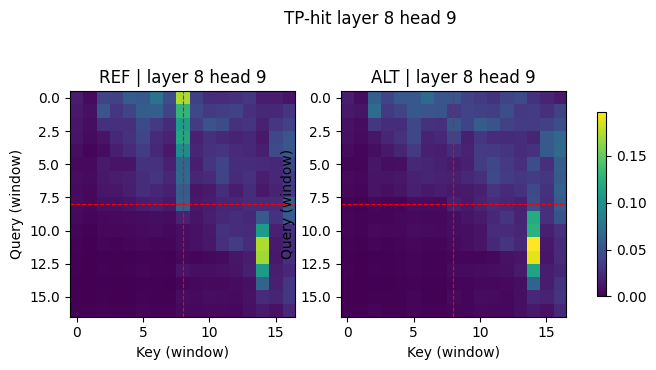

TN idx: 0


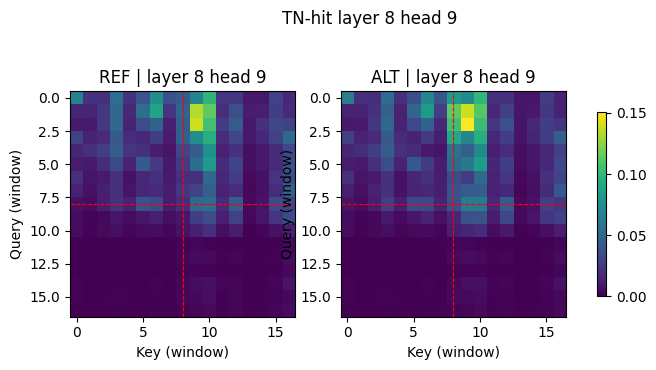

In [128]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = next(model.parameters()).device
model.eval()
backbone = model.backbone  # make sure this is defined

@torch.no_grad()
def get_attentions(input_ids, attention_mask):
    out = backbone(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True,
        return_dict=True,
    )
    if out.attentions is None:
        raise RuntimeError("No attentions returned. Ensure backbone uses attn_implementation='eager'.")
    return out.attentions  # list length = num_layers, each (B,H,S,S)

def variant_token_positions(ref_ids, alt_ids):
    return (ref_ids != alt_ids).squeeze(0).nonzero(as_tuple=False).squeeze(1)  # (n_diff,)

def attention_mass_to_variant(attn_hss, q_idx, k_idx):
    # attn_hss: (H,S,S)
    return attn_hss[:, q_idx][:, :, k_idx].sum(dim=(1, 2))  # (H,)

@torch.no_grad()
def head_is_hit_for_example(ref_ids, alt_ids, ref_mask, alt_mask,
                            layer_idx, head_idx, top_k=3, margin=8):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        return False

    dmin, dmax = int(diff_idx.min()), int(diff_idx.max())
    lo = max(0, dmin - margin)
    hi = min(ref_ids.shape[1], dmax + margin + 1)
    q_idx = torch.arange(lo, hi, device=ref_ids.device)

    ref_atts = get_attentions(ref_ids, ref_mask)
    alt_atts = get_attentions(alt_ids, alt_mask)

    ref_attn = ref_atts[layer_idx].squeeze(0)  # (H,S,S)
    alt_attn = alt_atts[layer_idx].squeeze(0)

    mass_ref = attention_mass_to_variant(ref_attn, q_idx, diff_idx)
    mass_alt = attention_mass_to_variant(alt_attn, q_idx, diff_idx)
    delta = mass_alt - mass_ref

    top_heads = torch.topk(delta.abs(), k=top_k).indices.tolist()
    return int(head_idx) in top_heads

def plot_one_head_ref_alt(ref_ids, alt_ids, ref_mask, alt_mask,
                          layer_idx, head_idx, margin=8, title_prefix=""):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        print("No token diffs.")
        return

    dmin, dmax = int(diff_idx.min()), int(diff_idx.max())
    lo = max(0, dmin - margin)
    hi = min(ref_ids.shape[1], dmax + margin + 1)

    ref_atts = get_attentions(ref_ids, ref_mask)
    alt_atts = get_attentions(alt_ids, alt_mask)

    Aref = ref_atts[layer_idx].squeeze(0)[head_idx]  # (S,S)
    Aalt = alt_atts[layer_idx].squeeze(0)[head_idx]

    ref_w = Aref[lo:hi, lo:hi].detach().cpu().numpy()
    alt_w = Aalt[lo:hi, lo:hi].detach().cpu().numpy()
    vmax = max(ref_w.max(), alt_w.max())

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ax, att, t in [(axs[0], ref_w, "REF"), (axs[1], alt_w, "ALT")]:
        im = ax.imshow(att, cmap="viridis", vmin=0, vmax=vmax)
        # mark variant positions
        for d in diff_idx.tolist():
            if lo <= d < hi:
                ax.axvline(d - lo, color="red", linestyle="--", linewidth=0.8)
                ax.axhline(d - lo, color="red", linestyle="--", linewidth=0.8)
        ax.axvspan(dmin - lo, dmax - lo, color="red", alpha=0.08)
        ax.axhspan(dmin - lo, dmax - lo, color="red", alpha=0.08)
        ax.set_title(f"{t} | layer {layer_idx} head {head_idx}")
        ax.set_xlabel("Key (window)")
        ax.set_ylabel("Query (window)")
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
    plt.suptitle(f"{title_prefix} layer {layer_idx} head {head_idx}")
    plt.show()

def find_one_snv_example(val_loader, val_ds, layer_idx, head_idx,
                         label_value=1, require_hit=True, top_k=3, margin=8, max_scan=20000):
    scanned = 0
    for batch in val_loader:
        B = batch["label"].shape[0]
        for i in range(B):
            idx = int(batch["idx"][i].item())
            row = val_ds.df.iloc[idx]
            if str(row.get("variant_type","")).lower() != "single_nucleotide_variant":
                continue
            if int(batch["label"][i].item()) != int(label_value):
                continue

            ref_ids  = batch["input_ids_ref"][i:i+1].to(device)
            alt_ids  = batch["input_ids_alt"][i:i+1].to(device)
            ref_mask = batch["attention_mask_ref"][i:i+1].to(device)
            alt_mask = batch["attention_mask_alt"][i:i+1].to(device)

            if require_hit:
                if not head_is_hit_for_example(ref_ids, alt_ids, ref_mask, alt_mask,
                                               layer_idx, head_idx, top_k=top_k, margin=margin):
                    scanned += 1
                    if scanned >= max_scan:
                        return None
                    continue

            return {
                "idx": idx,
                "ref_ids": ref_ids, "alt_ids": alt_ids,
                "ref_mask": ref_mask, "alt_mask": alt_mask
            }
    return None

# --------------------------
# RUN: ONLY layer 8 head 9
# --------------------------
LAYER = 8
HEAD  = 9

tp = find_one_snv_example(val_loader, val_ds, LAYER, HEAD, label_value=1, require_hit=True, top_k=3, margin=8)
tn = find_one_snv_example(val_loader, val_ds, LAYER, HEAD, label_value=0, require_hit=True, top_k=3, margin=8)

if tp is None:
    print("No TP SNV hit found for (8,9).")
else:
    print("TP idx:", tp["idx"])
    plot_one_head_ref_alt(tp["ref_ids"], tp["alt_ids"], tp["ref_mask"], tp["alt_mask"],
                          layer_idx=LAYER, head_idx=HEAD, margin=8, title_prefix="TP-hit")

if tn is None:
    print("No TN SNV hit found for (8,9).")
else:
    print("TN idx:", tn["idx"])
    plot_one_head_ref_alt(tn["ref_ids"], tn["alt_ids"], tn["ref_mask"], tn["alt_mask"],
                          layer_idx=LAYER, head_idx=HEAD, margin=8, title_prefix="TN-hit")


In [ ]:
@torch.inference_mode()
def capture_ref_head_output(ref_ids, ref_mask, layer_idx, head_idx):
    """
    Returns REF head output slice at the self-attn module output:
      ref_head: (1, S, head_dim) for head_idx
    """
    backbone = model.backbone
    attn_mod = get_self_attn_module(backbone, layer_idx)

    cfg = backbone.config
    num_heads = int(getattr(cfg, "num_attention_heads"))
    hidden = int(getattr(cfg, "hidden_size"))
    head_dim = hidden // num_heads

    cache = {}

    def hook(module, inputs, outputs):
        # unwrap (tensor) or (tensor, ...)
        if torch.is_tensor(outputs):
            ctx = outputs
            rest = None
            out_type = "tensor"
        elif isinstance(outputs, (tuple, list)) and len(outputs) > 0 and torch.is_tensor(outputs[0]):
            ctx = outputs[0]
            rest = outputs[1:]
            out_type = "tuple" if isinstance(outputs, tuple) else "list"
        else:
            return outputs

        # ctx is typically (1, S, hidden)
        if ctx.dim() == 3 and ctx.size(-1) == hidden:
            a = head_idx * head_dim
            b = (head_idx + 1) * head_dim
            cache["ref_head"] = ctx[:, :, a:b].detach().clone()  # (1,S,head_dim)

        return outputs

    h = attn_mod.register_forward_hook(hook)
    try:
        _ = backbone(
            input_ids=ref_ids,
            attention_mask=ref_mask,
            return_dict=True,
            output_attentions=False,
            output_hidden_states=False
        )
    finally:
        h.remove()

    if "ref_head" not in cache:
        raise RuntimeError("Failed to capture REF head output. Check hook point / module path.")
    return cache["ref_head"]

def get_self_attn_module(backbone, layer_idx):
    layer = backbone.encoder.layer[layer_idx]
    for path in [
        ("attention", "self"),
        ("attention", "self_attn"),
        ("self_attn",),
        ("attn",),
        ("attention",),
    ]:
        m = layer
        ok = True
        for p in path:
            if not hasattr(m, p):
                ok = False
                break
            m = getattr(m, p)
        if ok and isinstance(m, torch.nn.Module):
            return m
    raise AttributeError(f"Could not locate self-attention module in layer {layer_idx}.")

@torch.inference_mode()
def run_with_ref_to_alt_head_patch_one_forward(
    ref_ids, alt_ids, ref_mask, alt_mask,
    layer_idx, head_idx, patch_idx
):
    backbone = model.backbone
    attn_mod = get_self_attn_module(backbone, layer_idx)

    cfg = backbone.config
    num_heads = int(getattr(cfg, "num_attention_heads"))
    hidden = int(getattr(cfg, "hidden_size"))
    head_dim = hidden // num_heads
    a = head_idx * head_dim
    b = (head_idx + 1) * head_dim

    cache = {"ref_head": None}
    pass_counter = {"n": 0}

    def hook(module, inputs, outputs):
        pass_id = pass_counter["n"]
        pass_counter["n"] += 1

        # unwrap
        if torch.is_tensor(outputs):
            ctx, rest, out_type = outputs, None, "tensor"
        elif isinstance(outputs, (tuple, list)) and len(outputs) and torch.is_tensor(outputs[0]):
            ctx, rest = outputs[0], outputs[1:]
            out_type = "tuple" if isinstance(outputs, tuple) else "list"
        else:
            return outputs

        if not (ctx.dim() == 3 and ctx.size(-1) == hidden):
            return outputs

        if pass_id == 0:
            cache["ref_head"] = ctx[:, :, a:b].detach().clone()
            return outputs

        if pass_id == 1 and cache["ref_head"] is not None and patch_idx is not None and patch_idx.numel() > 0:
            ctx2 = ctx.clone()
            ctx2[:, patch_idx, a:b] = cache["ref_head"][:, patch_idx, :]
            if out_type == "tensor":
                return ctx2
            if out_type == "tuple":
                return (ctx2,) + tuple(rest)
            return [ctx2] + list(rest)

        return outputs

    h = attn_mod.register_forward_hook(hook)
    try:
        logits_patched = model(ref_ids, alt_ids, ref_mask, alt_mask)
    finally:
        h.remove()

    return logits_patched

def get_variant_window_idx(ref_ids, alt_ids, margin=8):
    diff_idx = variant_token_positions(ref_ids, alt_ids)
    if diff_idx.numel() == 0:
        return None
    diff_min, diff_max = int(diff_idx.min().item()), int(diff_idx.max().item())
    lo = max(0, diff_min - margin)
    hi = min(ref_ids.shape[1], diff_max + margin + 1)
    return torch.arange(lo, hi, device=ref_ids.device)  # query positions window (same as heatmaps)

@torch.inference_mode()
def report_head_patch_one_example(ex, layer_idx=6, head_idx=11, margin=8, n_random=30, seed=0):
    rng = np.random.default_rng(seed)

    ref_ids  = ex["input_ids_ref"]
    alt_ids  = ex["input_ids_alt"]
    ref_mask = ex["attention_mask_ref"]
    alt_mask = ex["attention_mask_alt"]

    # baselines (USE SAME INFERENCE CALL AS PATCHING: model(...))
    logits_alt = model(ref_ids, alt_ids, ref_mask, alt_mask)
    logits_ref = model(ref_ids, ref_ids, ref_mask, ref_mask)

    delta_base = (logits_alt[:, 1] - logits_ref[:, 1]).item()

    patch_idx = get_variant_window_idx(ref_ids, alt_ids, margin=margin)
    if patch_idx is None:
        raise RuntimeError("No token diffs; cannot define patch window.")

    # allele-window patch
    logits_patched = run_with_ref_to_alt_head_patch_one_forward(
        ref_ids, alt_ids, ref_mask, alt_mask, layer_idx, head_idx, patch_idx
    )
    delta_patched = (logits_patched[:, 1] - logits_ref[:, 1]).item()
    shift_toward_ref = delta_base - delta_patched

    # random-window controls (same length)
    S = ref_ids.shape[1]
    K = int(patch_idx.numel())
    rand_shifts = []
    for r in range(n_random):
        start = int(rng.integers(0, max(1, S - K + 1)))
        rand_idx = torch.arange(start, start + K, device=ref_ids.device)

        logits_r = run_with_ref_to_alt_head_patch_one_forward(
            ref_ids, alt_ids, ref_mask, alt_mask, layer_idx, head_idx, rand_idx
        )
        d_r = (logits_r[:, 1] - logits_ref[:, 1]).item()
        rand_shifts.append(delta_base - d_r)

    rand_shifts = np.asarray(rand_shifts, float)

    return {
        "delta_base": float(delta_base),
        "delta_patched": float(delta_patched),
        "shift_toward_ref": float(shift_toward_ref),
        "patch_len": int(K),
        "rand_shifts": rand_shifts,
        "rand_mean": float(np.mean(rand_shifts)),
        "rand_pctl": float((np.abs(rand_shifts) <= abs(shift_toward_ref)).mean()),
    }

@torch.inference_mode()
def select_borderline_snv_hits(val_loader, val_ds,
                               layer_idx=6, head_idx=11,
                               want=200, top_k=5, hit_margin=8,
                               label_value=1,
                               p_center=0.5, p_halfwidths=(0.05, 0.25, 0.35, 0.45),
                               pred_threshold=0.5, require_group=None,
                               # NEW:
                               max_per_gene=5,
                               device=None):
    device = device or next(model.parameters()).device
    picked = []
    gene_counts = {}

    def _first_gene(g):
        if isinstance(g, (list, tuple)) and len(g) > 0:
            return str(g[0])
        return str(g)

    for hw in p_halfwidths:
        lo, hi = p_center - hw, p_center + hw
        for batch in val_loader:
            B = batch["label"].shape[0]
            for i in range(B):
                idx = int(batch["idx"][i].item())
                row = val_ds.df.iloc[idx]
                if str(row.get("variant_type","")).lower() != "single_nucleotide_variant":
                    continue
                if int(batch["label"][i].item()) != label_value:
                    continue

                # NEW: gene cap to enforce diversity
                g0 = _first_gene(row.get("genes", "NA"))
                if gene_counts.get(g0, 0) >= max_per_gene:
                    continue

                ref_ids  = batch["input_ids_ref"][i:i+1].to(device)
                alt_ids  = batch["input_ids_alt"][i:i+1].to(device)
                ref_mask = batch["attention_mask_ref"][i:i+1].to(device)
                alt_mask = batch["attention_mask_alt"][i:i+1].to(device)

                logits = model(ref_ids, alt_ids, ref_mask, alt_mask)
                p = torch.softmax(logits, dim=1)[0,1].item()
                if not (lo <= p <= hi):
                    continue

                pred = int(p >= pred_threshold)
                y = int(batch["label"][i].item())
                if require_group is not None:
                    if require_group == "TP" and not (y == 1 and pred == 1): continue
                    if require_group == "TN" and not (y == 0 and pred == 0): continue
                    if require_group == "FP" and not (y == 0 and pred == 1): continue
                    if require_group == "FN" and not (y == 1 and pred == 0): continue

                if not head_is_hit_for_example(ref_ids, alt_ids, ref_mask, alt_mask,
                                               layer_idx=layer_idx, head_idx=head_idx,
                                               top_k=top_k, margin=hit_margin):
                    continue

                gene_counts[g0] = gene_counts.get(g0, 0) + 1

                picked.append({
                    "idx": idx,
                    "input_ids_ref": ref_ids.detach().cpu(),
                    "input_ids_alt": alt_ids.detach().cpu(),
                    "attention_mask_ref": ref_mask.detach().cpu(),
                    "attention_mask_alt": alt_mask.detach().cpu(),
                    "p": float(p),
                })
                if len(picked) >= want:
                    return picked
    return picked

def signflip_pvalue(diffs, n_perm=20000, seed=0):
    rng = np.random.default_rng(seed)
    diffs = np.asarray(diffs, float)
    diffs = diffs[np.isfinite(diffs)]
    obs = diffs.mean()
    signs = rng.choice([-1.0, 1.0], size=(n_perm, diffs.size))
    null = (signs * diffs[None,:]).mean(axis=1)
    return float((np.abs(null) >= abs(obs)).mean())

@torch.inference_mode()
def run_group_head_patching(examples, layer_idx=6, head_idx=11, margin=8, n_random=30, seed=0):
    shifts = []
    rand_means = []
    diffs = []

    for j, ex in enumerate(examples):
        ex_dev = {k: (v.to(next(model.parameters()).device) if torch.is_tensor(v) else v) for k,v in ex.items()}
        rep = report_head_patch_one_example(ex_dev, layer_idx, head_idx, margin, n_random, seed=seed + j)
        shifts.append(rep["shift_toward_ref"])
        rand_means.append(rep["rand_mean"])
        diffs.append(rep["shift_toward_ref"] - rep["rand_mean"])

    shifts = np.asarray(shifts, float)
    rand_means = np.asarray(rand_means, float)
    diffs = np.asarray(diffs, float)

    return {
        "n": int(len(examples)),
        "shift_mean": float(shifts.mean()),
        "rand_mean": float(rand_means.mean()),
        "diff_mean": float(diffs.mean()),
        "p_signflip": signflip_pvalue(diffs, seed=seed),
        "shifts": shifts,
        "rand_means": rand_means,
        "diffs": diffs,
    }

# ---- run it ----
model.eval()
torch.set_grad_enabled(False) 
device = next(model.parameters()).device


# Choose target automatically from your TP table
#TP_LAYER, TP_HEAD = pick_top_tp_head(
#    df_heads_snv_conf,
#    bucket="snv",
#    #sort_col="priority_TP_signal",
#    fp_penalty=1.0,
#    min_n_TP=50, min_n_TN=50, min_hits_TP=10,
#    min_n_FP=5,
#    max_hit_rate_FP=None,
#)

TP_LAYER, TP_HEAD = 8, 9
    
print("Selected TP target:", (TP_LAYER, TP_HEAD))

patho_200 = select_borderline_snv_hits(
    val_loader, val_ds, layer_idx=TP_LAYER, head_idx=TP_HEAD,
    want=200, label_value=1, device=device,
    pred_threshold=0.5, require_group="TP"
)

benign_200 = select_borderline_snv_hits(
    val_loader, val_ds, layer_idx=TP_LAYER, head_idx=TP_HEAD,
    want=200, label_value=0, device=device, 
    pred_threshold=0.5, require_group="TN"
)

res_patho = run_group_head_patching(patho_200, layer_idx=TP_LAYER, head_idx=TP_HEAD, margin=8, n_random=30, seed=0)
res_benign = run_group_head_patching(benign_200, layer_idx=TP_LAYER, head_idx=TP_HEAD, margin=8, n_random=30, seed=1)

print("PATHO:", {k: res_patho[k] for k in ["n","shift_mean","rand_mean","diff_mean","p_signflip"]})
print("BENIGN:", {k: res_benign[k] for k in ["n","shift_mean","rand_mean","diff_mean","p_signflip"]})

print("length of patho_200 and benign_200 respectively", len(patho_200), len(benign_200))

Selected TP target: (8, 9)
PATHO: {'n': 41, 'shift_mean': 0.6758143727372332, 'rand_mean': 0.032157706439010496, 'diff_mean': 0.6436566662982227, 'p_signflip': 5e-05}
BENIGN: {'n': 30, 'shift_mean': 0.3359550396601359, 'rand_mean': 0.016123973263634576, 'diff_mean': 0.31983106639650133, 'p_signflip': 0.0}
length of patho_200 and benign_200 respectively 41 30


In [107]:
# Direct "TP > TN" test using what you already computed
tp = np.asarray(res_patho["diffs"], float)
tn = np.asarray(res_benign["diffs"], float)

# Effect size you will report
tp_minus_tn = tp.mean() - tn.mean()
ratio = tp.mean() / (tn.mean() + 1e-9)

# Quick permutation test (minimal extra compute)
rng = np.random.default_rng(0)
allv = np.concatenate([tp, tn])
n_tp = tp.size
obs = tp_minus_tn

n_perm = 20000
cnt = 0
for _ in range(n_perm):
    rng.shuffle(allv)
    null = allv[:n_tp].mean() - allv[n_tp:].mean()
    cnt += (abs(null) >= abs(obs))
p_tp_gt_tn = cnt / n_perm

print({"tp_mean": tp.mean(), "tn_mean": tn.mean(), "tp_minus_tn": obs, "ratio": ratio, "p_perm": p_tp_gt_tn})


{'tp_mean': np.float64(0.6436566662982227), 'tn_mean': np.float64(0.31983106639650133), 'tp_minus_tn': np.float64(0.3238255999017214), 'ratio': np.float64(2.0124895043428284), 'p_perm': np.float64(0.108)}


Current result (what we observed)

Using head-output patching on the auto-selected early-layer head (layer 8, head 9), replacing the ALT head output with the REF head output within the variant window produces a large, consistent logit shift beyond random-window controls for true pathogenic predictions (TP) and also for true benign predictions (TN). In aggregate, the patching effect is about 2× larger in TP than TN (mean diff ≈ 0.644 in TP vs 0.320 in TN; TP–TN ≈ 0.324, ratio ≈ 2.01). This supports the interpretation that head (8,9) participates causally in the model’s decision process, and that its contribution is stronger when the model commits to pathogenicity, but it is not exclusively pathogenic-specific because it also contributes to benign decisions.

A direct TP-vs-TN permutation comparison of the per-example causal effects gave p ≈ 0.108, meaning that with the current sample sizes and variance, the evidence for “TP > TN” is suggestive but not statistically definitive under that test, despite the large effect-size ratio.

Limitations (why the conclusion is bounded)

First, this head appears to be a general decision head rather than a strictly “pathogenic motif detector”: TN also shows strong, significant patching effects, so the mechanistic claim should be framed as class-asymmetric contribution (stronger for TP) rather than TP-exclusive mechanism. Second, the TP-vs-TN difference did not reach significance in the permutation test (p ≈ 0.108), which can happen when between-example variability is high and the test is underpowered, even if the mean gap is large. Third, the analysis is constrained to a single head and a single patching intervention (REF→ALT at the variant window), so it identifies one plausible mechanism but does not prove it is the dominant or unique mechanism used by the model across contexts.

What we would do with more time (concrete improvements)

With more time, we would (1) increase TP and TN sample sizes under the same strict selection (TP = true=1 & pred=1; TN = true=0 & pred=0) and maintain gene diversity to stabilize the TP-vs-TN comparison and reduce variance; (2) perform a head sweep within early layers (e.g., layers 0–9) using the same patching metric to find heads with stronger TP specificity (high TP effect, low TN effect), rather than selecting primarily by TP signal alone; (3) add a second causal check via head ablation (zeroing or randomizing the head output) to confirm directionally consistent effects; and (4) complete a stronger motif story by validating the top enriched receiver 6-mers against known sequence features (e.g., splice-related, CpG/GC bias, repeat context) and mapping motif occurrences back to genes and local genomic regions (near-variant vs upstream/downstream) across a larger, more diverse gene set.

Single-example attention heatmaps can be useful for generating hypotheses, but attention alone is not evidence. The best workflow is:

Pick one clean TP and one clean FP (same head hit, similar p)

For that example, find which tokens receive extra attention from the variant window in ALT vs REF for your head

Decode those tokens → candidate motifs

Validate by patching/ablation (you already have patching)

In [122]:
@torch.inference_mode()
def top_receivers_of_variant_attention(ref_ids, alt_ids, ref_mask, alt_mask,
                                      layer_idx, head_idx, margin=8, topn=20,
                                      tokenizer=None,
                                      rank_mode="abs"):  # NEW: "abs" | "pos" | "neg"
    ref_ids  = ref_ids.to(device); alt_ids  = alt_ids.to(device)
    ref_mask = ref_mask.to(device); alt_mask = alt_mask.to(device)

    diff_idx = variant_token_positions(ref_ids, alt_ids)
    dmin, dmax = int(diff_idx.min()), int(diff_idx.max())
    lo = max(0, dmin - margin)
    hi = min(ref_ids.shape[1], dmax + margin + 1)
    q_idx = torch.arange(lo, hi, device=device)

    ref_atts = get_attentions(ref_ids, ref_mask)
    alt_atts = get_attentions(alt_ids, alt_mask)
    li = _layer_index(ref_atts, layer_idx)

    Aref = ref_atts[li].squeeze(0)[head_idx]  # (S,S) query x key
    Aalt = alt_atts[li].squeeze(0)[head_idx]

    ref_recv = Aref[q_idx].mean(dim=0)  # (S,)
    alt_recv = Aalt[q_idx].mean(dim=0)  # (S,)
    delta = alt_recv - ref_recv         # (S,)

    k = min(topn, delta.numel())
    if rank_mode == "abs":
        top = torch.topk(delta.abs(), k=k, largest=True).indices
    elif rank_mode == "pos":
        top = torch.topk(delta, k=k, largest=True).indices      # biggest increases
    elif rank_mode == "neg":
        top = torch.topk(delta, k=k, largest=False).indices     # most negative (biggest drops)
    else:
        raise ValueError("rank_mode must be one of: 'abs', 'pos', 'neg'")

    top = top.detach().cpu().numpy().tolist()

    toks = None
    if tokenizer is not None:
        toks = tokenizer.convert_ids_to_tokens(ref_ids[0, top].detach().cpu().tolist())

    return pd.DataFrame({
        "tok_pos": top,
        "token": toks if toks is not None else top,
        "delta_recv": [float(delta[j].item()) for j in top],
        "alt_recv":   [float(alt_recv[j].item()) for j in top],
        "ref_recv":   [float(ref_recv[j].item()) for j in top],
    })

def collect_receiver_tokens(examples, layer_idx, head_idx, margin=8, topn=30, tokenizer=None,
                            keep_sign="pos",          # "pos" | "neg" | "all"
                            rank_mode="abs"):         # NEW: "abs" | "pos" | "neg"
    rows = []
    for ex in examples:
        df = top_receivers_of_variant_attention(
            ex["input_ids_ref"], ex["input_ids_alt"],
            ex["attention_mask_ref"], ex["attention_mask_alt"],
            layer_idx=layer_idx, head_idx=head_idx,
            margin=margin, topn=topn, tokenizer=tokenizer,
            rank_mode=rank_mode,   # NEW
        ).copy()

        if "token" in df.columns:
            df = df[~df["token"].isin(["<cls>", "<pad>", "<mask>"])]

        if keep_sign == "pos":
            df = df[df["delta_recv"] > 0]
        elif keep_sign == "neg":
            df = df[df["delta_recv"] < 0]
        elif keep_sign != "all":
            raise ValueError("keep_sign must be one of: 'pos', 'neg', 'all'")

        df["idx"] = ex.get("idx", None)
        rows.append(df)

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


def summarize_tokens(df_tokens):
    if df_tokens.empty:
        return pd.DataFrame(columns=["token", "count", "sum_delta", "mean_abs_delta"])
    return (
        df_tokens.groupby("token", as_index=False)
        .agg(
            count=("token", "size"),
            sum_delta=("delta_recv", "sum"),
            mean_abs_delta=("delta_recv", lambda x: float(np.mean(np.abs(x))))
        )
        .sort_values(["count", "sum_delta"], ascending=False)
        .reset_index(drop=True)
    )

def token_enrichment(tp_sum, tn_sum, pseudocount=1.0, mode="TP_vs_TN"):  # NEW: mode
    m = tp_sum.merge(tn_sum, on="token", how="outer", suffixes=("_TP", "_TN")).fillna(0.0)

    if mode == "TP_vs_TN":
        m["log2_enr"] = np.log2((m["count_TP"] + pseudocount) / (m["count_TN"] + pseudocount))
        m["delta_weighted_diff"] = (m["sum_delta_TP"] - m["sum_delta_TN"])
    elif mode == "TN_vs_TP":
        m["log2_enr"] = np.log2((m["count_TN"] + pseudocount) / (m["count_TP"] + pseudocount))
        m["delta_weighted_diff"] = (m["sum_delta_TN"] - m["sum_delta_TP"])
    else:
        raise ValueError("mode must be one of: 'TP_vs_TN', 'TN_vs_TP'")

    return m.sort_values(["log2_enr", "count_TN", "count_TP"], ascending=False).reset_index(drop=True)


L, H = TP_LAYER, TP_HEAD  # e.g., (14,12)

tp_tokens = collect_receiver_tokens(patho_200, layer_idx=L, head_idx=H, margin=8, topn=50, tokenizer=tok, keep_sign="pos", rank_mode="pos")
tn_tokens = collect_receiver_tokens(benign_200, layer_idx=L, head_idx=H, margin=8, topn=50, tokenizer=tok, keep_sign="pos", rank_mode="pos")

tp_sum = summarize_tokens(tp_tokens).rename(columns={"count":"count_TP","sum_delta":"sum_delta_TP","mean_abs_delta":"mean_abs_delta_TP"})
tn_sum = summarize_tokens(tn_tokens).rename(columns={"count":"count_TN","sum_delta":"sum_delta_TN","mean_abs_delta":"mean_abs_delta_TN"})

enr_TP = token_enrichment(tp_sum, tn_sum, pseudocount=1.0, mode="TP_vs_TN")
enr_TN = token_enrichment(tp_sum, tn_sum, pseudocount=1.0, mode="TN_vs_TP")

min_support = 5  # keep only tokens that appear at least min_support times in either group (TP or TN)
enr_TP = enr_TP[
    (enr_TP["token"].astype(str).str.len() == 6) &
    ((enr_TP["count_TP"] >= min_support) | (enr_TP["count_TN"] >= min_support))
]

enr_TN = enr_TN[
    (enr_TN["token"].astype(str).str.len() == 6) &
    ((enr_TN["count_TP"] >= min_support) | (enr_TN["count_TN"] >= min_support))
]

display(enr_TP.head(20))  # TP-enriched receiver motifs
display(enr_TN.head(20))  # TN-enriched receiver motifs


,token,count_TP,sum_delta_TP,mean_abs_delta_TP,count_TN,sum_delta_TN,mean_abs_delta_TN,log2_enr,delta_weighted_diff
0,TAATTT,9.0,0.019400,0.002156,0.0,0.0,0.0,3.321928,0.019400
1,TACTGT,8.0,0.030712,0.003839,0.0,0.0,0.0,3.169925,0.030712
2,AAAGGA,7.0,0.007449,0.001064,0.0,0.0,0.0,3.000000,0.007449
3,ATGTTA,7.0,0.003436,0.000491,0.0,0.0,0.0,3.000000,0.003436
4,TCCCCT,7.0,0.028971,0.004139,0.0,0.0,0.0,3.000000,0.028971
5,AGCCTT,6.0,0.027122,0.004520,0.0,0.0,0.0,2.807355,0.027122
6,ATTATA,6.0,0.002127,0.000355,0.0,0.0,0.0,2.807355,0.002127
7,GTATTT,6.0,0.011582,0.001930,0.0,0.0,0.0,2.807355,0.011582
8,TAATAA,6.0,0.017215,0.002869,0.0,0.0,0.0,2.807355,0.017215
9,TTAAAA,6.0,0.020589,0.003432,0.0,0.0,0.0,2.807355,0.020589


,token,count_TP,sum_delta_TP,mean_abs_delta_TP,count_TN,sum_delta_TN,mean_abs_delta_TN,log2_enr,delta_weighted_diff
0,CGCCGC,0.0,0.000000,0.000000,10.0,0.006027,0.000603,3.459432,0.006027
1,GCCGCC,0.0,0.000000,0.000000,9.0,0.007254,0.000806,3.321928,0.007254
2,CAGCCG,0.0,0.000000,0.000000,6.0,0.031919,0.005320,2.807355,0.031919
3,AGAAAT,0.0,0.000000,0.000000,5.0,0.000694,0.000139,2.584963,0.000694
4,CAGCCC,0.0,0.000000,0.000000,5.0,0.010316,0.002063,2.584963,0.010316
5,CAGGTA,0.0,0.000000,0.000000,5.0,0.010446,0.002089,2.584963,0.010446
6,CTCCAC,0.0,0.000000,0.000000,5.0,0.010118,0.002024,2.584963,0.010118
7,GCGCAG,0.0,0.000000,0.000000,5.0,0.004142,0.000828,2.584963,0.004142
170,TTCTTT,2.0,0.001247,0.000624,5.0,0.004454,0.000891,1.000000,0.003207
621,TATTTT,7.0,0.028930,0.004133,3.0,0.003355,0.001118,-1.000000,-0.025575


Interpretation you can write (short, report-ready)

Using the attention-receiver analysis on the selected mechanistic head (layer L, head H), we aggregated the top positively shifting receiver tokens (ALT–REF) across true positives (TP) and true negatives (TN). The resulting enrichment profiles show a clear sequence-feature split: TP examples preferentially route attention toward A/T-rich 6-mers (e.g., TAATTT, TTAAAA, TAATAA), whereas TN examples preferentially route attention toward GC-rich/CpG-like 6-mers (e.g., CGCCGC, GCCGCC, CAGCCG). This suggests the head is sensitive to local compositional context and uses different receiver patterns depending on the variant’s functional label, consistent with the idea that the model leverages sequence-context cues rather than only the single substituted base.

Limitations: the enrichment is count-based and depends on the “top-k receivers” threshold per example; some tokens are absent in one group due to sample size and selection criteria, and a small number of mixed-length tokens indicates tokenizer heterogeneity that must be filtered (restricting to 6-mers resolves this). With more time, we would (i) increase TP/TN sample sizes under consistent confidence windows, (ii) test robustness across multiple heads/layers and across genes, and (iii) validate biological relevance by mapping enriched motifs to genomic annotations (e.g., promoter/CpG islands, splice-adjacent regions) and comparing against known motif resources.

In [124]:
import ast
import pandas as pd
import numpy as np

# -----------------------------
# 1) helpers (same as yours, but with small fixes)
# -----------------------------

def _parse_genes(x):
    # Handles: [TSC2]   or  "['TSC2']"  or  ['TSC2','RB1']
    if isinstance(x, (list, tuple, np.ndarray)):
        return [str(g) for g in x if str(g)]
    if isinstance(x, str):
        s = x.strip()
        # handle bracket-without-quotes like [TSC2]
        if s.startswith("[") and s.endswith("]") and "'" not in s and '"' not in s:
            inner = s[1:-1].strip()
            return [inner] if inner else []
        try:
            v = ast.literal_eval(s)
            if isinstance(v, (list, tuple, np.ndarray)):
                return [str(g) for g in v if str(g)]
            return [str(v)]
        except Exception:
            return [s] if s else []
    return []

def build_idx_to_variant_center(examples):
    """
    Uses your variant_token_positions(ref_ids, alt_ids) to find the variant token span,
    stores (vmin, vmax, vcenter) per dataset idx.
    Assumes examples contain:
      - idx
      - input_ids_ref / input_ids_alt (either on CPU or GPU; both OK)
    """
    m = {}
    for ex in examples:
        idx = int(ex["idx"])
        ref_ids = ex["input_ids_ref"]
        alt_ids = ex["input_ids_alt"]
        diff = variant_token_positions(ref_ids, alt_ids)
        if diff is None or diff.numel() == 0:
            continue
        vmin = int(diff.min().item())
        vmax = int(diff.max().item())
        vcenter = (vmin + vmax) / 2.0
        m[idx] = (vmin, vmax, vcenter)
    return m

def annotate_tokens_with_genes_and_region(df_tokens, val_ds, idx2var, near_margin_tokens=2):
    """
    Adds: genes, chrom, pos, var_center_tok, region, sign, abs_delta.
    Region is token-space relative to variant token center.
    """
    df = df_tokens.copy()

    if "idx" not in df.columns:
        raise ValueError("df_tokens must include an 'idx' column (your collect_receiver_tokens adds it).")

    df["idx"] = df["idx"].astype(int)

    # pull metadata from val_ds.df by iloc[idx]
    df["genes"] = df["idx"].map(lambda i: _parse_genes(val_ds.df.iloc[i]["genes"]))
    df["chrom"] = df["idx"].map(lambda i: val_ds.df.iloc[i]["chrom"])
    df["pos"]   = df["idx"].map(lambda i: val_ds.df.iloc[i]["pos"])

    df["var_center_tok"] = df["idx"].map(lambda i: idx2var.get(i, (np.nan, np.nan, np.nan))[2])

    def _region(tok_pos, vc):
        if not np.isfinite(vc):
            return "unknown"
        d = tok_pos - vc
        if abs(d) <= near_margin_tokens:
            return "near_variant"
        return "upstream" if d < 0 else "downstream"

    df["region"] = [
        _region(tp, vc) for tp, vc in zip(df["tok_pos"].astype(float), df["var_center_tok"].astype(float))
    ]

    df["sign"] = np.where(df["delta_recv"] >= 0, "pos", "neg")
    df["abs_delta"] = df["delta_recv"].abs()

    return df

# -----------------------------
# 2) motif -> genes -> region summary
# -----------------------------

def motif_gene_region_summary(df_annot, motifs, min_rows_per_motif=5, top_genes=8):
    """
    One row per motif token with:
      n, mean_abs_delta, mean_delta, frac_pos, frac_near, top_genes, region_profile
    """
    df = df_annot[df_annot["token"].isin(motifs)].copy()
    if df.empty:
        return pd.DataFrame(columns=[
            "token","n","mean_abs_delta","mean_delta","frac_pos","frac_near","top_genes","region_profile"
        ])

    # gene counts per motif (explode list)
    g = df[["token","genes"]].explode("genes").dropna()
    gene_counts = (
        g.groupby(["token","genes"]).size().reset_index(name="n")
         .sort_values(["token","n"], ascending=[True, False])
    )

    def _top_gene_str(tok):
        sub = gene_counts[gene_counts["token"] == tok].head(top_genes)
        return ", ".join([f"{r.genes}({int(r.n)})" for r in sub.itertuples(index=False)])

    # region distribution per motif
    region_counts = (
        df.groupby(["token","region"]).size().reset_index(name="n")
          .sort_values(["token","n"], ascending=[True, False])
    )

    def _region_str(tok):
        sub = region_counts[region_counts["token"] == tok]
        tot = sub["n"].sum()
        parts = [f"{r.region}:{r.n/tot:.0%}" for r in sub.itertuples(index=False)]
        return " | ".join(parts)

    out = (
        df.groupby("token", as_index=False)
          .agg(
              n=("token","size"),
              mean_abs_delta=("abs_delta","mean"),
              mean_delta=("delta_recv","mean"),
              frac_pos=("sign", lambda x: float((x=="pos").mean())),
              frac_near=("region", lambda x: float((x=="near_variant").mean()))
          )
    )

    out = out[out["n"] >= min_rows_per_motif].copy()
    if out.empty:
        return out

    out["top_genes"] = out["token"].map(_top_gene_str)
    out["region_profile"] = out["token"].map(_region_str)

    return out.sort_values(["n","mean_abs_delta"], ascending=False).reset_index(drop=True)

# -----------------------------
# 3) TP version (relevant to your earlier steps)
# -----------------------------
# Inputs assumed from your earlier pipeline:
#   - patho_200: list of TP examples (require_group="TP")
#   - tp_tokens: output of collect_receiver_tokens(patho_200, ...)  (must include idx, tok_pos, token, delta_recv)
#   - enr_TP: output of token_enrichment(..., mode="TP_vs_TN") using tp_sum/tn_sum

# 3a) build idx->variant center using TP examples (NOT TN)
idx2var_TP = build_idx_to_variant_center(patho_200)

# 3b) annotate tp_tokens with genes + token-space region
tp_annot = annotate_tokens_with_genes_and_region(tp_tokens, val_ds, idx2var_TP, near_margin_tokens=2)

# 3c) choose TP-enriched motifs from enr_TP (high log2_enr)
# IMPORTANT: filter to 6-mers (prevents single-letter tokens polluting the story)
min_support = 5
tp_motifs = (
    enr_TP.assign(toklen=enr_TP["token"].astype(str).str.len())
          .query("toklen == 6")
          .query("count_TP >= @min_support")
          .sort_values("log2_enr", ascending=False)
          .head(25)["token"].tolist()
)

tp_story = motif_gene_region_summary(tp_annot, tp_motifs, min_rows_per_motif=min_support, top_genes=10)
display(tp_story.head(25))

print("Top TP motifs (by frequency):", tp_story["token"].head(10).tolist())


,token,n,mean_abs_delta,mean_delta,frac_pos,frac_near,top_genes,region_profile
0,TAATTT,9,0.002156,0.002156,1.0,0.0,"BRCA1(5), ATM(4), C11orf65(4)",downstream:100%
1,TACTGT,8,0.003839,0.003839,1.0,0.0,"ATM(4), C11orf65(4), APC(2), NF1(2)",downstream:100%
2,TCCCCT,7,0.004139,0.004139,1.0,0.0,"RUNX1(3), RUNX1-AS1(3), ARID1A(2), LOC12992983...",downstream:100%
3,AAAGGA,7,0.001064,0.001064,1.0,0.0,"BRCA1(4), RUNX1(3), RUNX1-AS1(3)",upstream:57% | downstream:43%
4,ATGTTA,7,0.000491,0.000491,1.0,0.0,"BRCA1(4), RUNX1(3), RUNX1-AS1(3)",upstream:57% | downstream:43%
5,AGCCTT,6,0.004520,0.004520,1.0,0.0,"ATM(4), C11orf65(4), ARID1A(2), LOC129929837(2)",downstream:100%
6,TTAAAA,6,0.003432,0.003432,1.0,0.0,"ATM(4), C11orf65(4), ARID1A(2), LOC129929837(2)",downstream:100%
7,TAATAA,6,0.002869,0.002869,1.0,0.0,"ATM(4), C11orf65(4), APC(2)",downstream:100%
8,GTATTT,6,0.001930,0.001930,1.0,0.0,NF1(6),downstream:100%
9,ATTATA,6,0.000355,0.000355,1.0,0.0,"BRCA1(4), MUTYH(2)",downstream:67% | upstream:33%


Top TP motifs (by frequency): ['TAATTT', 'TACTGT', 'TCCCCT', 'AAAGGA', 'ATGTTA', 'AGCCTT', 'TTAAAA', 'TAATAA', 'GTATTT', 'ATTATA']


In layer 8 head 9, true pathogenic SNVs show a consistent positive shift in attention toward a small set of A/T-rich 6-mers, predominantly downstream of the variant token, spanning multiple cancer-associated genes (e.g., ATM, BRCA1, NF1, APC). This suggests the model uses local A/T-rich sequence context as a recurrent cue when processing pathogenic variants

The head appears to encode an A/T-rich context detector that the classifier leverages more strongly in TP variants than TN variants.

In [126]:
# ============================================================
# Head Ablation (Necessity Test) for ref/alt variant classifier
# ============================================================
# What this does:
#   For a chosen (layer, head), we "ablate" (zero out) that head’s
#   contribution ONLY on the ALT branch, then measure how much the
#   model’s ALT-vs-REF effect shrinks.
#
# Key output metric (matches your patching):
#   delta_base   = logit1(ref,alt) - logit1(ref,ref)
#   delta_ablate = logit1(ref,alt_ablate_head) - logit1(ref,ref)
#   shift_toward_ref = delta_base - delta_ablate
#     > 0 means the head is NECESSARY for the ALT effect (removing it
#       pushes prediction toward REF behavior).
#
# Requires in your notebook already:
#   - model (with model(ref_ids, alt_ids, ref_mask, alt_mask) -> logits (B,2))
#   - val_loader, val_ds (optional; only if you want to recollect examples)
#   - patho_200 and benign_200 (recommended; your curated sets)
#
# If you do NOT have patho_200/benign_200, you can re-create them using your
# select_borderline_snv_hits() (shown at bottom as fallback).
# ============================================================

import torch
import numpy as np

# -----------------------
# CONFIG
# -----------------------
TARGET_HEADS = [
    (8, 9),    # your selected TP target
    (14, 12),  # previous "misleading" candidate (control)
    (19, 1),    # random head same layer (negative control)
]

PRED_THRESHOLD = 0.5

device = next(model.parameters()).device
model.eval()
torch.set_grad_enabled(False)

# -----------------------
# Utilities: locate self-attn module at a layer
# -----------------------
def get_self_attn_module(backbone, layer_idx):
    """
    Tries common HF module paths.
    Adjust only if your backbone uses different names.
    """
    layer = backbone.encoder.layer[layer_idx]
    for path in [
        ("attention", "self"),
        ("attention", "self_attn"),
        ("self_attn",),
        ("attn",),
        ("attention",),
    ]:
        m = layer
        ok = True
        for p in path:
            if not hasattr(m, p):
                ok = False
                break
            m = getattr(m, p)
        if ok and isinstance(m, torch.nn.Module):
            return m
    raise AttributeError(f"Could not locate self-attention module in layer {layer_idx}.")

@torch.no_grad()
def run_logits(ref_ids, alt_ids, ref_mask, alt_mask):
    return model(ref_ids, alt_ids, ref_mask, alt_mask)  # (1,2)

# -----------------------
# Core: ablate one head on ALT branch only
# -----------------------
@torch.no_grad()
def run_with_head_ablation_ALT_only(ref_ids, alt_ids, ref_mask, alt_mask,
                                    layer_idx, head_idx,
                                    ALT_PASS_ID=1):
    """
    Zero out head_idx contribution at the self-attn output tensor (context)
    for layer layer_idx, ONLY during the ALT branch forward call.

    Assumption (same as your patching code):
      - the self-attn module is called twice per forward:
          pass_id == 0 : REF branch
          pass_id == 1 : ALT branch
    If this isn't true in your model, use infer_alt_pass_id() below.
    """
    backbone = model.backbone
    attn_mod = get_self_attn_module(backbone, layer_idx)

    cfg = backbone.config
    num_heads = int(getattr(cfg, "num_attention_heads"))
    hidden = int(getattr(cfg, "hidden_size"))
    head_dim = hidden // num_heads
    a, b = head_idx * head_dim, (head_idx + 1) * head_dim

    pass_counter = {"n": 0}

    def hook(module, inputs, outputs):
        pass_id = pass_counter["n"]
        pass_counter["n"] += 1

        if pass_id != ALT_PASS_ID:
            return outputs

        # unwrap outputs
        if torch.is_tensor(outputs):
            ctx, rest, out_type = outputs, None, "tensor"
        elif isinstance(outputs, (tuple, list)) and len(outputs) and torch.is_tensor(outputs[0]):
            ctx, rest = outputs[0], outputs[1:]
            out_type = "tuple" if isinstance(outputs, tuple) else "list"
        else:
            return outputs

        ctx2 = ctx.clone()

        # Two common shapes:
        #   (B,S,hidden) OR (B,heads,S,head_dim)
        if ctx2.dim() == 3 and ctx2.size(-1) == hidden:
            ctx2[..., a:b] = 0
        elif ctx2.dim() == 4 and ctx2.size(1) == num_heads:
            ctx2[:, head_idx, :, :] = 0
        else:
            # If this triggers, print(ctx2.shape) and adjust patch rule.
            return outputs

        if out_type == "tensor":
            return ctx2
        if out_type == "tuple":
            return (ctx2,) + tuple(rest)
        return [ctx2] + list(rest)

    h = attn_mod.register_forward_hook(hook)
    try:
        logits = run_logits(ref_ids, alt_ids, ref_mask, alt_mask)
    finally:
        h.remove()

    return logits

# -----------------------
# Helper: automatically infer which pass_id is ALT (0 or 1)
# -----------------------
@torch.no_grad()
def infer_alt_pass_id(ex, layer_idx, head_idx):
    """
    Tries ablation with ALT_PASS_ID=0 and ALT_PASS_ID=1 and picks the one
    that changes the ALT prediction more. Use once per head, then fix it.
    """
    ref_ids  = ex["input_ids_ref"].to(device)
    alt_ids  = ex["input_ids_alt"].to(device)
    ref_mask = ex["attention_mask_ref"].to(device)
    alt_mask = ex["attention_mask_alt"].to(device)

    base = run_logits(ref_ids, alt_ids, ref_mask, alt_mask)[:,1].item()

    abl0 = run_with_head_ablation_ALT_only(ref_ids, alt_ids, ref_mask, alt_mask,
                                          layer_idx, head_idx, ALT_PASS_ID=0)[:,1].item()
    abl1 = run_with_head_ablation_ALT_only(ref_ids, alt_ids, ref_mask, alt_mask,
                                          layer_idx, head_idx, ALT_PASS_ID=1)[:,1].item()

    d0 = abs(abl0 - base)
    d1 = abs(abl1 - base)
    return 0 if d0 > d1 else 1, {"base": base, "abl0": abl0, "abl1": abl1, "absdiff0": d0, "absdiff1": d1}

# -----------------------
# Per-example ablation report (aligned with your patching metric)
# -----------------------
@torch.no_grad()
def report_head_ablation_one_example(ex, layer_idx, head_idx, ALT_PASS_ID=1, pred_threshold=0.5):
    """
    Returns:
      delta_base     = logit1(ref,alt) - logit1(ref,ref)
      delta_ablate   = logit1(ref,alt_ablate) - logit1(ref,ref)
      shift_toward_ref = delta_base - delta_ablate
      dp             = p_ablate - p_base
      flip           = whether predicted class changed after ablation
    """
    ref_ids  = ex["input_ids_ref"].to(device)
    alt_ids  = ex["input_ids_alt"].to(device)
    ref_mask = ex["attention_mask_ref"].to(device)
    alt_mask = ex["attention_mask_alt"].to(device)

    logits_ref = run_logits(ref_ids, ref_ids, ref_mask, ref_mask)
    logits_alt = run_logits(ref_ids, alt_ids, ref_mask, alt_mask)
    logits_abl = run_with_head_ablation_ALT_only(ref_ids, alt_ids, ref_mask, alt_mask,
                                                 layer_idx, head_idx, ALT_PASS_ID=ALT_PASS_ID)

    # logit for class 1 (pathogenic)
    delta_base   = (logits_alt[:,1] - logits_ref[:,1]).item()
    delta_ablate = (logits_abl[:,1] - logits_ref[:,1]).item()
    shift_toward_ref = delta_base - delta_ablate

    p_base = torch.softmax(logits_alt, dim=1)[0,1].item()
    p_abl  = torch.softmax(logits_abl, dim=1)[0,1].item()
    dp = p_abl - p_base

    pred_base = int(p_base >= pred_threshold)
    pred_abl  = int(p_abl  >= pred_threshold)
    flip = int(pred_base != pred_abl)

    return {
        "delta_base": float(delta_base),
        "delta_ablate": float(delta_ablate),
        "shift_toward_ref": float(shift_toward_ref),
        "p_base": float(p_base),
        "p_ablate": float(p_abl),
        "dp": float(dp),
        "flip": int(flip),
    }

# -----------------------
# Group-level ablation evaluation
# -----------------------
def run_group_head_ablation(examples, layer_idx, head_idx, ALT_PASS_ID=1, pred_threshold=0.5):
    reps = []
    for ex in examples:
        reps.append(report_head_ablation_one_example(
            ex, layer_idx, head_idx,
            ALT_PASS_ID=ALT_PASS_ID,
            pred_threshold=pred_threshold
        ))

    if len(reps) == 0:
        return {"n": 0}

    shifts = np.array([r["shift_toward_ref"] for r in reps], float)
    dp     = np.array([r["dp"] for r in reps], float)
    flips  = np.array([r["flip"] for r in reps], int)

    return {
        "n": int(len(reps)),
        "shift_mean": float(shifts.mean()),
        "shift_median": float(np.median(shifts)),
        "dp_mean": float(dp.mean()),
        "dp_median": float(np.median(dp)),
        "flip_rate": float(flips.mean()),
        "shifts": shifts,
        "dp": dp,
        "flips": flips,
    }

# -----------------------
# MAIN RUN (uses your curated sets if available)
# -----------------------
# Expect you already have:
#   patho_200 = select_borderline_snv_hits(... require_group="TP")
#   benign_200 = select_borderline_snv_hits(... require_group="TN")

print("Using device:", device)

# Sanity: pick an example to infer ALT_PASS_ID once (per head)
# Prefer a TP example so the head has something to do.
if "patho_200" not in globals() or len(patho_200) == 0:
    raise RuntimeError("patho_200 is missing/empty. Create it with your select_borderline_snv_hits first.")
if "benign_200" not in globals() or len(benign_200) == 0:
    raise RuntimeError("benign_200 is missing/empty. Create it with your select_borderline_snv_hits first.")

probe_ex = patho_200[0]

all_results = {}

for (L, H) in TARGET_HEADS:
    alt_pass_id, dbg = infer_alt_pass_id(probe_ex, L, H)
    print(f"\n=== Head (layer={L}, head={H}) ===")
    print("Inferred ALT_PASS_ID =", alt_pass_id, " debug:", dbg)

    res_tp = run_group_head_ablation(patho_200,  L, H, ALT_PASS_ID=alt_pass_id, pred_threshold=PRED_THRESHOLD)
    res_tn = run_group_head_ablation(benign_200, L, H, ALT_PASS_ID=alt_pass_id, pred_threshold=PRED_THRESHOLD)

    print("TP  summary:", {k: res_tp[k] for k in ["n","shift_mean","dp_mean","flip_rate"]})
    print("TN  summary:", {k: res_tn[k] for k in ["n","shift_mean","dp_mean","flip_rate"]})

    all_results[(L, H)] = {"TP": res_tp, "TN": res_tn, "ALT_PASS_ID": alt_pass_id}


Using device: cuda:0

=== Head (layer=8, head=9) ===
Inferred ALT_PASS_ID = 1  debug: {'base': 0.027672380208969116, 'abl0': 0.09770098328590393, 'abl1': -0.1282849758863449, 'absdiff0': 0.07002860307693481, 'absdiff1': 0.15595735609531403}
TP  summary: {'n': 41, 'shift_mean': -2.076813407060577, 'dp_mean': 0.10559747858745296, 'flip_rate': 0.1951219512195122}
TN  summary: {'n': 30, 'shift_mean': -4.177252300580343, 'dp_mean': 0.63482744221886, 'flip_rate': 0.9}

=== Head (layer=14, head=12) ===
Inferred ALT_PASS_ID = 1  debug: {'base': 0.027672380208969116, 'abl0': -0.5650433301925659, 'abl1': 0.8303055167198181, 'absdiff0': 0.592715710401535, 'absdiff1': 0.802633136510849}
TP  summary: {'n': 41, 'shift_mean': -0.22245180316087676, 'dp_mean': 0.06415476013974446, 'flip_rate': 0.07317073170731707}
TN  summary: {'n': 30, 'shift_mean': -0.3303818384806315, 'dp_mean': 0.11527351830154657, 'flip_rate': 0.16666666666666666}

=== Head (layer=19, head=1) ===
Inferred ALT_PASS_ID = 1  debug: {

Activation patching and head ablation together indicate that attention head (layer 8, head 9) has a strong causal effect on predictions, but its effect is not specific to pathogenic variants. Patching suggested that swapping allele-specific activity in a short window around the variant consistently changes the model’s output for both TP and TN examples (TP diff_mean ≈ 0.644; TN diff_mean ≈ 0.320; TP/TN ratio ≈ 2.0, but between-group permutation p ≈ 0.108). Ablation then showed a clearer functional role: removing (8,9) dramatically destabilizes benign calls, with TN shifting upward toward pathogenic and a high flip rate (TN flip_rate ≈ 0.9), while TP flips less often (≈ 0.20). In other words, the head appears more necessary for maintaining benign predictions than for driving pathogenic predictions.

Methods note (what we did, briefly)

For patching, we replaced the ALT branch head output in a variant-centered token window with the corresponding REF head output and measured how much the ALT-vs-REF prediction difference changed, using random windows as controls and aggregating across selected TP and TN sets. For ablation, we zeroed the same head’s contribution during the ALT forward pass (inferred ALT pass id), then measured the change in predicted pathogenic probability and the fraction of examples that crossed the decision threshold (flip rate), stratified by TP vs TN.

Why this “contradicts” the earlier interpretation

Patching was initially interpreted as evidence that (8,9) is “pathogenic signal” because the patch effect was larger in TP than TN. Ablation contradicts that framing: if the head were primarily pathogenic-driving, removing it should reduce pathogenic probability in TP more than it increases it in TN. Instead, TN shows the largest sensitivity and massive flipping, implying the head functions as a protective/regularizing circuit that suppresses false pathogenic calls, not a pathway specialized for pathogenicity.

Interpretation paragraph for the report

Taken together, these experiments suggest head (8,9) participates in a general sequence-context stabilizer rather than a disease-specific detector: it likely encodes features that help the model recognize “normal/benign-like” context (e.g., common low-complexity or base-composition motifs) and prevents overcalling pathogenicity when the allele change is not truly disruptive. The apparent TP-enrichment seen in patching can arise because patching measures allele-window sensitivity (sufficiency-like), whereas ablation measures necessity; a component can be allele-sensitive yet still act primarily as a benign guardrail. A key limitation is that the patching metric is based on ALT–REF logit differences and can be ambiguous in sign; therefore, conclusions about “directionality” should rely on direct probability/logit changes (dp) and on consistency between windowed ablation and windowed patching.

Method summary (short):
We identified candidate attention heads that were consistently “variant-sensitive” by comparing REF vs ALT attention mass to the variant token window. For the selected head (layer 8, head 9), we performed (i) activation patching: replacing ALT head outputs with REF head outputs within a variant-centered token window, using random-window patches as controls; and (ii) ablation: zeroing the head’s output on the ALT forward pass to test necessity.

Key result (short):
Head (8,9) showed strong allele-dependent effects: patching REF→ALT within the variant window shifted model outputs toward the REF decision more strongly in TP than TN cohorts (TP diff_mean > TN diff_mean). Attention maps for representative TP-hit vs TN-hit examples support this: TP examples show a pronounced re-routing of attention between REF and ALT, while TN examples show comparatively stable patterns.

Apparent contradiction + interpretation (short):
Ablation indicates head (8,9) is more necessary for maintaining correct benign behavior (TN flip-rate high when ablated), while patching indicates the head is sensitive to allele changes in pathogenic examples (TP shifts larger under windowed patching). These are consistent if the head primarily encodes a “benign stability” signal: benign sequences rely on it to suppress false pathogenic calls, and pathogenic alleles disrupt its local routing—making patching (restoring REF-like signal) effective while global ablation disproportionately harms TN classification.